In [1]:
import os
import random

import torch
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

from tqdm import tqdm   # show loops progress

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version from PyTorch: {torch.version.cuda}")

PyTorch version: 2.5.1
CUDA version from PyTorch: 12.1


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4070 Ti SUPER


**SEED**

In [4]:
SEED:int = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**LOAD TRAIN DATA**

In [5]:
# Dataset personalizado para DRIVE
class Dataset(Dataset):
    def __init__(self, image_dir, ground_truth, transform=None, transform_img=None):
        self.image_dir = image_dir
        self.ground_truth_dir = ground_truth
        self.image_filenames = os.listdir(image_dir)  
        self.mask_filenames = os.listdir(ground_truth)   
        self.transform = transform
        self.transform_img = transform_img

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        ground_truth_path = os.path.join(self.ground_truth_dir, self.mask_filenames[idx])
        
        image = Image.open(image_path).convert('RGB')
        ground_truth = Image.open(ground_truth_path).convert('L')  # gt to grayscale
        
        # image to tensor (needed to concatenate and more)
        image = transforms.ToTensor()(image)
        ground_truth = transforms.ToTensor()(ground_truth)
        
        if self.transform:        # exactly same transformations to image and gt
            # Concatenate along channel dimension.
            # Here, dim=0 is the channel dimension (not the batch dim) (here we have [C, H, W])
            image_and_gt = torch.cat([image, ground_truth], dim=0) 
            
            # Transform together
            transformed = self.transform(image_and_gt)

            # Slice the tensors out
            image = transformed[:3, :, :]    
            ground_truth = (transformed[3:, :, :] > 0.5).float()       # binarize !!!
        
        
        if self.transform_img:       # transformations only for images
            image = self.transform_img(image)
            

        return image, ground_truth, self.image_filenames[idx]

In [6]:
# Routes for training data
image_dir = './data/CHASE/training/images'
ground_truth_dir = './data/CHASE/training/2nd_manual'

''' # Just compute the mean and std
from torchvision import datasets
# calculate mean and std
dataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

NORM_MEAN = 0.
NORM_STD = 0.
for images, _, _ in dataloader:
    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)
    NORM_STD += images.std([0, 2, 3])    # channels std

NORM_MEAN /= len(dataloader)
NORM_STD /= len(dataloader)

print(f"Mean: {NORM_MEAN}")
print(f"Std: {NORM_STD}")'''

' # Just compute the mean and std\nfrom torchvision import datasets\n# calculate mean and std\ndataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)\n\nNORM_MEAN = 0.\nNORM_STD = 0.\nfor images, _, _ in dataloader:\n    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)\n    NORM_STD += images.std([0, 2, 3])    # channels std\n\nNORM_MEAN /= len(dataloader)\nNORM_STD /= len(dataloader)\n\nprint(f"Mean: {NORM_MEAN}")\nprint(f"Std: {NORM_STD}")'

In [7]:
IMG_SIZE:int = 512
DATA_AUG_PROB:float = 0.85

from torchvision.transforms import v2

# transforms for images and its ground truth segmentations (same for both)
transform = v2.Compose([
    v2.RandomApply([
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        #v2.RandomZoomOut(fill=0, p=0.2), 
        v2.RandomAffine(degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.5, 1.5)),
        #v2.RandomResizedCrop(IMG_SIZE),
        #v2.ElasticTransform(alpha=15.0),
        #v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
        
    ], p=DATA_AUG_PROB),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    
    # transforms.Grayscale(num_output_channels=1),       # we want rgb    
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])

# transform just for the image
transform_img = v2.Compose([
    v2.RandomApply([
        v2.ColorJitter(brightness=[0.6, 1.2], contrast=[0.3, 1.3], saturation=[0.5, 1.3], hue=0.015),
        v2.RandomAdjustSharpness(sharpness_factor=1.5),
        #v2.GaussianNoise(),

    ], p=DATA_AUG_PROB),
     
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])


dataset = Dataset(image_dir, ground_truth_dir, transform=transform, transform_img=transform_img)

In [8]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)
for img, gt, _ in example_loader:
    print(img.shape)
    print(gt.shape)
    print("\n")
    break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])




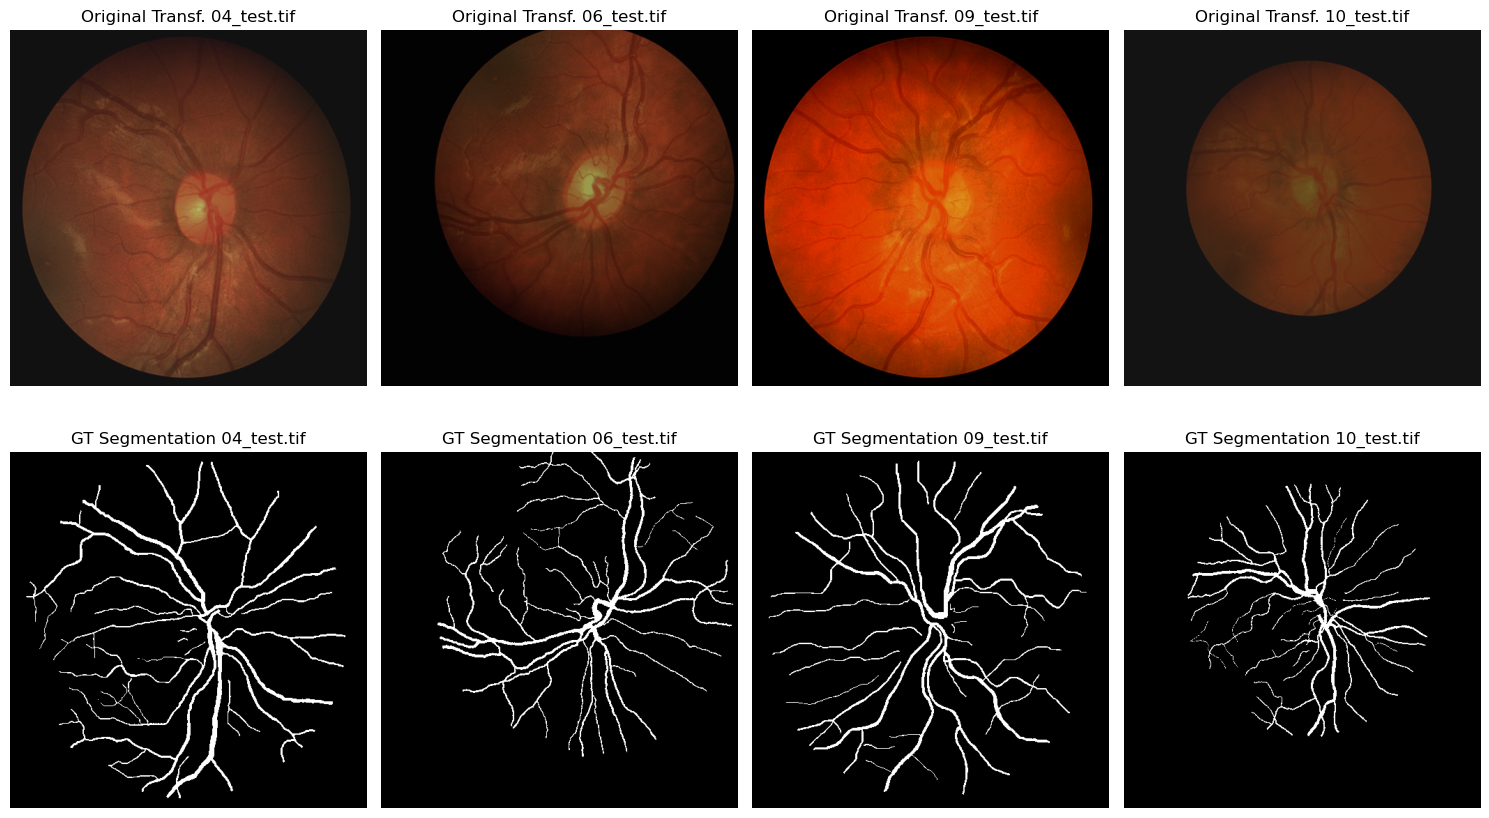

In [9]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# Obtener algunas imágenes y máscaras del example_loader
data_iter = iter(example_loader)
images, ground_truth, img_name = next(data_iter)

# Convertir los tensores a formato numpy para visualizarlos
images = images.numpy().transpose(0, 2, 3, 1)  # [N, C, H, W] a [N, H, W, C]
ground_truth = ground_truth.numpy()  # [N, H, W] para las máscaras

# Eliminar la dimensión extra (1, H, W) de las máscaras
ground_truth = np.squeeze(ground_truth)  # Esto convierte la forma (1, H, W) a (H, W)

# Visualizar las imágenes en la fila superior y las máscaras en la fila inferior
fig, axes = plt.subplots(2, 4, figsize=(15, 9))  # 2 filas, 4 columnas (imágenes arriba y máscaras abajo)

for i in range(4):
    # Mostrar la imagen en la fila superior
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original Transf. {img_name[i]}')
    
    # Mostrar la máscara en la fila inferior
    axes[1, i].imshow(ground_truth[i], cmap='gray')  # show as grayscale
    axes[1, i].axis('off')
    axes[1, i].set_title(f'GT Segmentation {img_name[i]}')

plt.tight_layout()
plt.show()

**DATA SPLITTING**

In [10]:
VAL_PERCENT:float = 0.1            # Percentage of dataset intended for validation (rest is for training) 
BATCH_SIZE:int = 4

# Split into train / validation partitions
val_size = int(len(dataset) * VAL_PERCENT)     # number of samples for validation
train_size = len(dataset) - val_size           # number of samples for training
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print('Training set has {} instances'.format(train_size))
print('Validation set has {} instances'.format(val_size))

Training set has 18 instances
Validation set has 2 instances


In [11]:
sample_image, sample_gt, _ = train_set[0]

NUM_CHANNELS_IN:int = sample_image.size(0)  
NUM_CHANNELS_OUT:int = sample_gt.size(0)

print(f"Number of channels in input: {NUM_CHANNELS_IN}")
print(f"Number of channels in output: {NUM_CHANNELS_OUT}")

Number of channels in input: 3
Number of channels in output: 1


**CREATE MODEL**

In [12]:
from unet import UNet
model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)

# cuda if available, cpu if not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device.type=}")
model.to(device)      # move to cuda if possible

#from torchsummary import summary
#summary(model, (NUM_CHANNELS_IN, IMG_SIZE, IMG_SIZE))

device.type='cuda'


UNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128, e

**SOME HYPERPARAMETERS, SAVE PATH, CUDA**

In [13]:
EPOCHS:int = 1000

# save best model state path
SAVE_PATH = "./trained_models"
       

# LOSS FUNCTION -----------------------------------------------------
from utils.loss_functions import DiceLoss, DiceBCELoss, DiceBCELossWithTopology
#(need sigmoid at the end of network)

#loss_fn = torch.nn.BCELoss()        # binary cross-entropy loss 
#loss_fn = DiceLoss()
loss_fn = DiceBCELoss(bce_weight=0.5)      # weight of BCE
#loss_fn = DiceBCELossWithTopology(bce_weight=0.5, topology_weight=0.5, image_pixels=IMG_SIZE*IMG_SIZE)


# OPTIMIZER ---------------------------------------------------------
LEARNING_RATE:float = 0.001
MOMENTUM:float = 0.9
WEIGHT_DECAY:float = 1e-2

#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

optimizer = torch.optim.AdamW([
    {'params': model.parameters()},  # Parámetros del modelo
    {'params': loss_fn.parameters()}  # Parámetros de la pérdida
], lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

**TRAIN FUNCTION**

In [14]:
def training_loop(epochs, model, train_dataloader, val_dataloader, 
                  loss_fn, optimizer, save_path, patience=30):
    
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy':[], 'val_accuracy':[]}
    best_val_loss = float('inf')  # Initialize to infinity
    best_model_state = None
    datetime_start = datetime.now()
    
    early_stopping_counter = 0  # Counter for early stopping

    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss = 0
        train_correct_pred = 0
        total_train_pred = 0
        
        for data in tqdm(train_dataloader):      # for each training batch
            
            img, ground_truth, _ = data
            img, ground_truth = img.to(device), ground_truth.to(device)     # move to cuda, if possible
            
            pred = model(img)
            # print(f"Pred shape: {pred.shape}, Ground truth shape: {ground_truth.shape}")   # debug
            # print(torch.max(pred))
            # print(torch.min(pred))
            # print(f"Pred device: {pred.device}, Ground truth device: {ground_truth.device}")
            # print(f"Pred type: {type(pred)}")
            # print(f"Pred content: {pred}")

            # print(f"Ground truth values: {ground_truth.unique()}")
            # print("\n")

            loss = loss_fn(pred, ground_truth)
            # print(loss)
            # print(loss.shape)
            running_train_loss += loss.item()
            train_correct_pred += ((pred > 0.5).float() == ground_truth).sum()      # add number of correct predictions
            total_train_pred += IMG_SIZE*IMG_SIZE*len(img)            # add number of predictions made (pixels per img * number of imgs)
            
            loss.backward()            # calculate gradients
            optimizer.step()           # update model parameters
            optimizer.zero_grad()      # reset gradients
        
        model.eval()
        with torch.no_grad():
            running_val_loss = 0
            val_correct_pred = 0
            total_val_pred = 0
            
            for data in tqdm(val_dataloader):      # for each validation batch
                
                img, ground_truth, _ = data
                img, ground_truth = img.to(device), ground_truth.to(device)       # move to cuda, if possible
                
                pred = model(img)
                loss = loss_fn(pred, ground_truth)
                
                running_val_loss += loss.item()
                val_correct_pred += ((pred > 0.5).float() == ground_truth).sum()         # add number of correct predictions
                total_val_pred += IMG_SIZE*IMG_SIZE*len(img)                     # add number of predictions made (pixels per img * number of imgs)


        train_loss = running_train_loss / len(train_dataloader.dataset)
        val_loss = running_val_loss / len(val_dataloader.dataset)
        train_acc = train_correct_pred / total_train_pred * 100       # % of average accuracy in training, in this epoch
        val_acc = val_correct_pred / total_val_pred * 100             # % of average accuracy in validation, in this epoch

        history['train_loss'].append(train_loss)         # add metrics in this epoch to the record
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss:.5f} | Validation loss: {val_loss:.5f} | Training accuracy: {train_acc:.2f}% | Validation accuracy: {val_acc:.2f}%')
        print(f"\n")
        
        # Save the model if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the model state
            early_stopping_counter = 0   # Reset counter if validation loss improves
        else:
            early_stopping_counter += 1
            print(f"Validation loss did not improve. Early stopping counter: {early_stopping_counter}/{patience}")
        
        # Stop training if patience is exceeded
        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break
        
    # Save the best model state
    if best_model_state is not None:
        model_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)
        torch.save(best_model_state, model_path)    
        print(f'Best model saved at {model_path}')
    
    # save history (dictionary)
    history_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)+'_history'
    torch.save(history, history_path)
    print(f'\nHistory saved at {history_path}')
    
    model.eval()
    return history

In [15]:
# TRAIN THE CURRENT MODEL
start_time = datetime.now()

PATIENCE = 100

history = training_loop(EPOCHS, model, train_loader, val_loader, 
                        loss_fn, optimizer, SAVE_PATH, PATIENCE)

end_time = datetime.now()
print(f"\nTraining duration: {end_time - start_time}")

100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 1/1000 | Training loss: 0.30656 | Validation loss: 0.61204 | Training accuracy: 84.78% | Validation accuracy: 94.62%




100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


Epoch: 2/1000 | Training loss: 0.29534 | Validation loss: 0.64371 | Training accuracy: 86.99% | Validation accuracy: 54.65%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


Epoch: 3/1000 | Training loss: 0.27195 | Validation loss: 0.67263 | Training accuracy: 87.96% | Validation accuracy: 55.13%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 4/1000 | Training loss: 0.25592 | Validation loss: 1.57620 | Training accuracy: 90.35% | Validation accuracy: 76.73%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Epoch: 5/1000 | Training loss: 0.24671 | Validation loss: 0.51991 | Training accuracy: 91.98% | Validation accuracy: 94.75%




100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Epoch: 6/1000 | Training loss: 0.24195 | Validation loss: 0.51475 | Training accuracy: 92.07% | Validation accuracy: 98.18%




100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


Epoch: 7/1000 | Training loss: 0.21872 | Validation loss: 0.52362 | Training accuracy: 92.30% | Validation accuracy: 89.77%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


Epoch: 8/1000 | Training loss: 0.21439 | Validation loss: 0.51290 | Training accuracy: 93.58% | Validation accuracy: 95.15%




100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


Epoch: 9/1000 | Training loss: 0.19960 | Validation loss: 0.43119 | Training accuracy: 93.12% | Validation accuracy: 94.34%




100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


Epoch: 10/1000 | Training loss: 0.20077 | Validation loss: 0.45705 | Training accuracy: 94.80% | Validation accuracy: 95.96%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


Epoch: 11/1000 | Training loss: 0.18395 | Validation loss: 0.41326 | Training accuracy: 93.71% | Validation accuracy: 93.02%




100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


Epoch: 12/1000 | Training loss: 0.17955 | Validation loss: 0.47049 | Training accuracy: 94.56% | Validation accuracy: 95.56%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


Epoch: 13/1000 | Training loss: 0.17321 | Validation loss: 0.37472 | Training accuracy: 94.30% | Validation accuracy: 94.99%




100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


Epoch: 14/1000 | Training loss: 0.17130 | Validation loss: 0.39471 | Training accuracy: 93.63% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


Epoch: 15/1000 | Training loss: 0.15977 | Validation loss: 0.35490 | Training accuracy: 94.27% | Validation accuracy: 96.02%




100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


Epoch: 16/1000 | Training loss: 0.16919 | Validation loss: 0.35158 | Training accuracy: 93.93% | Validation accuracy: 93.76%




100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


Epoch: 17/1000 | Training loss: 0.16010 | Validation loss: 0.29668 | Training accuracy: 94.64% | Validation accuracy: 96.82%




100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Epoch: 18/1000 | Training loss: 0.15761 | Validation loss: 0.40780 | Training accuracy: 94.07% | Validation accuracy: 91.36%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


Epoch: 19/1000 | Training loss: 0.15591 | Validation loss: 0.42692 | Training accuracy: 93.98% | Validation accuracy: 95.60%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


Epoch: 20/1000 | Training loss: 0.15059 | Validation loss: 0.40690 | Training accuracy: 95.44% | Validation accuracy: 94.59%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


Epoch: 21/1000 | Training loss: 0.14633 | Validation loss: 0.38763 | Training accuracy: 95.13% | Validation accuracy: 86.20%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 22/1000 | Training loss: 0.14615 | Validation loss: 0.28456 | Training accuracy: 94.71% | Validation accuracy: 95.34%




100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 23/1000 | Training loss: 0.14221 | Validation loss: 0.25110 | Training accuracy: 95.09% | Validation accuracy: 96.34%




100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


Epoch: 24/1000 | Training loss: 0.13620 | Validation loss: 0.21480 | Training accuracy: 95.41% | Validation accuracy: 96.57%




100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


Epoch: 25/1000 | Training loss: 0.13264 | Validation loss: 0.22673 | Training accuracy: 95.03% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


Epoch: 26/1000 | Training loss: 0.13304 | Validation loss: 0.24781 | Training accuracy: 95.62% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


Epoch: 27/1000 | Training loss: 0.12775 | Validation loss: 0.19353 | Training accuracy: 95.25% | Validation accuracy: 96.34%




100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 28/1000 | Training loss: 0.12734 | Validation loss: 0.21061 | Training accuracy: 95.52% | Validation accuracy: 96.05%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


Epoch: 29/1000 | Training loss: 0.12796 | Validation loss: 0.23402 | Training accuracy: 95.52% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 30/1000 | Training loss: 0.12434 | Validation loss: 0.29837 | Training accuracy: 95.82% | Validation accuracy: 95.31%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


Epoch: 31/1000 | Training loss: 0.13527 | Validation loss: 0.20997 | Training accuracy: 95.15% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 32/1000 | Training loss: 0.12956 | Validation loss: 0.20914 | Training accuracy: 96.09% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


Epoch: 33/1000 | Training loss: 0.12362 | Validation loss: 0.25788 | Training accuracy: 95.61% | Validation accuracy: 92.93%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


Epoch: 34/1000 | Training loss: 0.13066 | Validation loss: 0.33355 | Training accuracy: 94.45% | Validation accuracy: 94.79%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Epoch: 35/1000 | Training loss: 0.12458 | Validation loss: 0.32630 | Training accuracy: 95.69% | Validation accuracy: 94.96%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


Epoch: 36/1000 | Training loss: 0.12098 | Validation loss: 0.22854 | Training accuracy: 95.54% | Validation accuracy: 95.38%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


Epoch: 37/1000 | Training loss: 0.11901 | Validation loss: 0.42971 | Training accuracy: 95.33% | Validation accuracy: 90.29%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch: 38/1000 | Training loss: 0.12186 | Validation loss: 0.24188 | Training accuracy: 95.95% | Validation accuracy: 96.34%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


Epoch: 39/1000 | Training loss: 0.12493 | Validation loss: 0.19771 | Training accuracy: 95.05% | Validation accuracy: 96.30%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


Epoch: 40/1000 | Training loss: 0.11721 | Validation loss: 0.26710 | Training accuracy: 96.19% | Validation accuracy: 95.03%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 41/1000 | Training loss: 0.11508 | Validation loss: 0.39207 | Training accuracy: 96.02% | Validation accuracy: 93.49%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Epoch: 42/1000 | Training loss: 0.13167 | Validation loss: 0.20206 | Training accuracy: 95.55% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


Epoch: 43/1000 | Training loss: 0.11440 | Validation loss: 0.21366 | Training accuracy: 95.55% | Validation accuracy: 95.24%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


Epoch: 44/1000 | Training loss: 0.11278 | Validation loss: 0.20889 | Training accuracy: 96.11% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Epoch: 45/1000 | Training loss: 0.11092 | Validation loss: 0.18760 | Training accuracy: 95.54% | Validation accuracy: 97.34%




100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


Epoch: 46/1000 | Training loss: 0.12127 | Validation loss: 0.25993 | Training accuracy: 96.25% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


Epoch: 47/1000 | Training loss: 0.11649 | Validation loss: 0.21463 | Training accuracy: 95.69% | Validation accuracy: 94.21%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 48/1000 | Training loss: 0.10836 | Validation loss: 0.19746 | Training accuracy: 96.14% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


Epoch: 49/1000 | Training loss: 0.12592 | Validation loss: 0.24328 | Training accuracy: 95.95% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Epoch: 50/1000 | Training loss: 0.11095 | Validation loss: 0.32849 | Training accuracy: 95.66% | Validation accuracy: 94.37%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


Epoch: 51/1000 | Training loss: 0.10487 | Validation loss: 0.31262 | Training accuracy: 96.04% | Validation accuracy: 95.77%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 52/1000 | Training loss: 0.11306 | Validation loss: 0.18107 | Training accuracy: 96.42% | Validation accuracy: 96.93%




100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch: 53/1000 | Training loss: 0.10575 | Validation loss: 0.47255 | Training accuracy: 96.45% | Validation accuracy: 92.69%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


Epoch: 54/1000 | Training loss: 0.10446 | Validation loss: 0.17763 | Training accuracy: 96.42% | Validation accuracy: 97.00%




100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 55/1000 | Training loss: 0.10494 | Validation loss: 0.24138 | Training accuracy: 96.27% | Validation accuracy: 95.22%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Epoch: 56/1000 | Training loss: 0.11129 | Validation loss: 0.18331 | Training accuracy: 95.70% | Validation accuracy: 95.32%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Epoch: 57/1000 | Training loss: 0.10278 | Validation loss: 0.28218 | Training accuracy: 95.97% | Validation accuracy: 93.19%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Epoch: 58/1000 | Training loss: 0.10533 | Validation loss: 0.21586 | Training accuracy: 96.87% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Epoch: 59/1000 | Training loss: 0.10167 | Validation loss: 0.26091 | Training accuracy: 96.54% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Epoch: 60/1000 | Training loss: 0.11589 | Validation loss: 0.17080 | Training accuracy: 96.01% | Validation accuracy: 98.30%




100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Epoch: 61/1000 | Training loss: 0.10384 | Validation loss: 0.18360 | Training accuracy: 95.89% | Validation accuracy: 96.04%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Epoch: 62/1000 | Training loss: 0.11035 | Validation loss: 0.21734 | Training accuracy: 96.57% | Validation accuracy: 95.30%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


Epoch: 63/1000 | Training loss: 0.09917 | Validation loss: 0.22642 | Training accuracy: 96.22% | Validation accuracy: 94.41%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Epoch: 64/1000 | Training loss: 0.10348 | Validation loss: 0.17881 | Training accuracy: 96.02% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Epoch: 65/1000 | Training loss: 0.10196 | Validation loss: 0.21912 | Training accuracy: 96.00% | Validation accuracy: 96.60%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 66/1000 | Training loss: 0.10126 | Validation loss: 0.33870 | Training accuracy: 96.20% | Validation accuracy: 95.31%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 67/1000 | Training loss: 0.10209 | Validation loss: 0.17706 | Training accuracy: 96.33% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


Epoch: 68/1000 | Training loss: 0.10104 | Validation loss: 0.19879 | Training accuracy: 96.30% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 69/1000 | Training loss: 0.10068 | Validation loss: 0.24614 | Training accuracy: 96.24% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Epoch: 70/1000 | Training loss: 0.10479 | Validation loss: 0.17972 | Training accuracy: 96.40% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 71/1000 | Training loss: 0.10013 | Validation loss: 0.20127 | Training accuracy: 96.48% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


Epoch: 72/1000 | Training loss: 0.10356 | Validation loss: 0.19229 | Training accuracy: 96.45% | Validation accuracy: 98.37%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


Epoch: 73/1000 | Training loss: 0.10394 | Validation loss: 0.21258 | Training accuracy: 96.23% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 74/1000 | Training loss: 0.10804 | Validation loss: 0.17176 | Training accuracy: 96.37% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 75/1000 | Training loss: 0.09654 | Validation loss: 0.16869 | Training accuracy: 96.86% | Validation accuracy: 97.33%




100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Epoch: 76/1000 | Training loss: 0.10308 | Validation loss: 0.26567 | Training accuracy: 96.76% | Validation accuracy: 98.33%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


Epoch: 77/1000 | Training loss: 0.10108 | Validation loss: 0.27573 | Training accuracy: 96.20% | Validation accuracy: 93.69%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


Epoch: 78/1000 | Training loss: 0.10279 | Validation loss: 0.16474 | Training accuracy: 96.00% | Validation accuracy: 97.68%




100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


Epoch: 79/1000 | Training loss: 0.09757 | Validation loss: 0.20815 | Training accuracy: 96.33% | Validation accuracy: 98.51%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


Epoch: 80/1000 | Training loss: 0.09783 | Validation loss: 0.18952 | Training accuracy: 96.55% | Validation accuracy: 96.27%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 81/1000 | Training loss: 0.10410 | Validation loss: 0.22235 | Training accuracy: 95.44% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 82/1000 | Training loss: 0.09916 | Validation loss: 0.20357 | Training accuracy: 96.74% | Validation accuracy: 96.07%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


Epoch: 83/1000 | Training loss: 0.09468 | Validation loss: 0.18815 | Training accuracy: 96.79% | Validation accuracy: 98.56%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


Epoch: 84/1000 | Training loss: 0.09183 | Validation loss: 0.17183 | Training accuracy: 96.92% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Epoch: 85/1000 | Training loss: 0.09853 | Validation loss: 0.18241 | Training accuracy: 96.31% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Epoch: 86/1000 | Training loss: 0.09770 | Validation loss: 0.21242 | Training accuracy: 96.12% | Validation accuracy: 96.17%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Epoch: 87/1000 | Training loss: 0.09955 | Validation loss: 0.22120 | Training accuracy: 96.82% | Validation accuracy: 95.64%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 88/1000 | Training loss: 0.10224 | Validation loss: 0.16789 | Training accuracy: 95.82% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


Epoch: 89/1000 | Training loss: 0.09552 | Validation loss: 0.17100 | Training accuracy: 96.10% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


Epoch: 90/1000 | Training loss: 0.09320 | Validation loss: 0.15599 | Training accuracy: 96.53% | Validation accuracy: 96.94%




100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


Epoch: 91/1000 | Training loss: 0.09222 | Validation loss: 0.17610 | Training accuracy: 96.62% | Validation accuracy: 95.46%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 92/1000 | Training loss: 0.09427 | Validation loss: 0.16055 | Training accuracy: 96.53% | Validation accuracy: 95.92%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


Epoch: 93/1000 | Training loss: 0.09119 | Validation loss: 0.19400 | Training accuracy: 96.70% | Validation accuracy: 95.99%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 94/1000 | Training loss: 0.09314 | Validation loss: 0.17754 | Training accuracy: 96.10% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


Epoch: 95/1000 | Training loss: 0.09458 | Validation loss: 0.15869 | Training accuracy: 96.65% | Validation accuracy: 98.54%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


Epoch: 96/1000 | Training loss: 0.09199 | Validation loss: 0.25332 | Training accuracy: 96.39% | Validation accuracy: 95.41%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Epoch: 97/1000 | Training loss: 0.09031 | Validation loss: 0.17036 | Training accuracy: 96.96% | Validation accuracy: 98.20%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


Epoch: 98/1000 | Training loss: 0.09298 | Validation loss: 0.33387 | Training accuracy: 96.63% | Validation accuracy: 95.18%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


Epoch: 99/1000 | Training loss: 0.10190 | Validation loss: 0.16400 | Training accuracy: 95.31% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Epoch: 100/1000 | Training loss: 0.09260 | Validation loss: 0.19525 | Training accuracy: 96.07% | Validation accuracy: 95.91%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 101/1000 | Training loss: 0.08992 | Validation loss: 0.16600 | Training accuracy: 96.81% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 102/1000 | Training loss: 0.09278 | Validation loss: 0.24968 | Training accuracy: 96.33% | Validation accuracy: 95.95%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Epoch: 103/1000 | Training loss: 0.09235 | Validation loss: 0.16741 | Training accuracy: 96.56% | Validation accuracy: 98.48%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


Epoch: 104/1000 | Training loss: 0.09218 | Validation loss: 0.27520 | Training accuracy: 96.74% | Validation accuracy: 94.93%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


Epoch: 105/1000 | Training loss: 0.09624 | Validation loss: 0.18213 | Training accuracy: 96.41% | Validation accuracy: 96.18%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Epoch: 106/1000 | Training loss: 0.09147 | Validation loss: 0.19296 | Training accuracy: 97.31% | Validation accuracy: 96.19%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Epoch: 107/1000 | Training loss: 0.09621 | Validation loss: 0.18670 | Training accuracy: 96.07% | Validation accuracy: 96.10%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Epoch: 108/1000 | Training loss: 0.09221 | Validation loss: 0.14967 | Training accuracy: 96.68% | Validation accuracy: 97.69%




100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Epoch: 109/1000 | Training loss: 0.09343 | Validation loss: 0.17853 | Training accuracy: 96.19% | Validation accuracy: 98.40%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


Epoch: 110/1000 | Training loss: 0.09036 | Validation loss: 0.16965 | Training accuracy: 96.69% | Validation accuracy: 95.93%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


Epoch: 111/1000 | Training loss: 0.09557 | Validation loss: 0.20942 | Training accuracy: 96.92% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


Epoch: 112/1000 | Training loss: 0.09725 | Validation loss: 0.25633 | Training accuracy: 96.00% | Validation accuracy: 95.75%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 113/1000 | Training loss: 0.09289 | Validation loss: 0.16348 | Training accuracy: 96.18% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 114/1000 | Training loss: 0.09368 | Validation loss: 0.17079 | Training accuracy: 96.35% | Validation accuracy: 98.15%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


Epoch: 115/1000 | Training loss: 0.09354 | Validation loss: 0.17078 | Training accuracy: 96.57% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Epoch: 116/1000 | Training loss: 0.09116 | Validation loss: 0.25490 | Training accuracy: 96.86% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


Epoch: 117/1000 | Training loss: 0.08950 | Validation loss: 0.16060 | Training accuracy: 96.55% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 118/1000 | Training loss: 0.08819 | Validation loss: 0.16404 | Training accuracy: 96.70% | Validation accuracy: 95.57%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Epoch: 119/1000 | Training loss: 0.09227 | Validation loss: 0.15719 | Training accuracy: 96.81% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Epoch: 120/1000 | Training loss: 0.09150 | Validation loss: 0.19762 | Training accuracy: 96.26% | Validation accuracy: 95.97%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Epoch: 121/1000 | Training loss: 0.09345 | Validation loss: 0.15355 | Training accuracy: 96.19% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


Epoch: 122/1000 | Training loss: 0.09316 | Validation loss: 0.17812 | Training accuracy: 97.69% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


Epoch: 123/1000 | Training loss: 0.09734 | Validation loss: 0.24287 | Training accuracy: 96.42% | Validation accuracy: 93.85%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Epoch: 124/1000 | Training loss: 0.09075 | Validation loss: 0.18385 | Training accuracy: 96.84% | Validation accuracy: 98.00%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Epoch: 125/1000 | Training loss: 0.08818 | Validation loss: 0.17916 | Training accuracy: 97.11% | Validation accuracy: 98.23%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


Epoch: 126/1000 | Training loss: 0.08975 | Validation loss: 0.15121 | Training accuracy: 96.77% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Epoch: 127/1000 | Training loss: 0.09167 | Validation loss: 0.15878 | Training accuracy: 96.80% | Validation accuracy: 98.39%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 128/1000 | Training loss: 0.09151 | Validation loss: 0.20958 | Training accuracy: 96.71% | Validation accuracy: 94.73%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Epoch: 129/1000 | Training loss: 0.09144 | Validation loss: 0.15529 | Training accuracy: 96.71% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Epoch: 130/1000 | Training loss: 0.08939 | Validation loss: 0.20657 | Training accuracy: 97.03% | Validation accuracy: 94.90%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


Epoch: 131/1000 | Training loss: 0.09123 | Validation loss: 0.17680 | Training accuracy: 96.49% | Validation accuracy: 96.17%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


Epoch: 132/1000 | Training loss: 0.09000 | Validation loss: 0.16423 | Training accuracy: 96.70% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


Epoch: 133/1000 | Training loss: 0.09234 | Validation loss: 0.16021 | Training accuracy: 96.05% | Validation accuracy: 98.58%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


Epoch: 134/1000 | Training loss: 0.09116 | Validation loss: 0.17476 | Training accuracy: 96.74% | Validation accuracy: 95.82%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


Epoch: 135/1000 | Training loss: 0.08728 | Validation loss: 0.19427 | Training accuracy: 97.34% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch: 136/1000 | Training loss: 0.09107 | Validation loss: 0.14363 | Training accuracy: 96.89% | Validation accuracy: 97.82%




100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 137/1000 | Training loss: 0.08681 | Validation loss: 0.17243 | Training accuracy: 96.76% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 138/1000 | Training loss: 0.09039 | Validation loss: 0.14570 | Training accuracy: 97.13% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Epoch: 139/1000 | Training loss: 0.08606 | Validation loss: 0.14542 | Training accuracy: 97.17% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Epoch: 140/1000 | Training loss: 0.08899 | Validation loss: 0.15754 | Training accuracy: 96.54% | Validation accuracy: 96.14%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Epoch: 141/1000 | Training loss: 0.08650 | Validation loss: 0.17010 | Training accuracy: 96.55% | Validation accuracy: 96.15%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 142/1000 | Training loss: 0.08945 | Validation loss: 0.15340 | Training accuracy: 96.52% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Epoch: 143/1000 | Training loss: 0.08716 | Validation loss: 0.16608 | Training accuracy: 96.93% | Validation accuracy: 96.04%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 144/1000 | Training loss: 0.08492 | Validation loss: 0.16311 | Training accuracy: 97.00% | Validation accuracy: 96.01%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Epoch: 145/1000 | Training loss: 0.08374 | Validation loss: 0.15512 | Training accuracy: 97.56% | Validation accuracy: 95.87%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 146/1000 | Training loss: 0.08609 | Validation loss: 0.14582 | Training accuracy: 96.92% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Epoch: 147/1000 | Training loss: 0.08394 | Validation loss: 0.14484 | Training accuracy: 97.31% | Validation accuracy: 96.45%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch: 148/1000 | Training loss: 0.08703 | Validation loss: 0.15180 | Training accuracy: 96.50% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 149/1000 | Training loss: 0.08765 | Validation loss: 0.14799 | Training accuracy: 96.72% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


Epoch: 150/1000 | Training loss: 0.08463 | Validation loss: 0.16298 | Training accuracy: 97.06% | Validation accuracy: 95.65%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 151/1000 | Training loss: 0.08514 | Validation loss: 0.19494 | Training accuracy: 96.74% | Validation accuracy: 95.95%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Epoch: 152/1000 | Training loss: 0.08587 | Validation loss: 0.14659 | Training accuracy: 96.62% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 153/1000 | Training loss: 0.09081 | Validation loss: 0.14488 | Training accuracy: 96.36% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 154/1000 | Training loss: 0.08590 | Validation loss: 0.15416 | Training accuracy: 97.04% | Validation accuracy: 98.77%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


Epoch: 155/1000 | Training loss: 0.08485 | Validation loss: 0.24417 | Training accuracy: 96.75% | Validation accuracy: 94.87%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 156/1000 | Training loss: 0.08448 | Validation loss: 0.14920 | Training accuracy: 96.92% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


Epoch: 157/1000 | Training loss: 0.08751 | Validation loss: 0.42129 | Training accuracy: 96.85% | Validation accuracy: 85.00%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Epoch: 158/1000 | Training loss: 0.08564 | Validation loss: 0.24712 | Training accuracy: 97.28% | Validation accuracy: 92.28%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Epoch: 159/1000 | Training loss: 0.08970 | Validation loss: 0.18518 | Training accuracy: 96.74% | Validation accuracy: 94.87%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


Epoch: 160/1000 | Training loss: 0.08693 | Validation loss: 0.14592 | Training accuracy: 96.70% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


Epoch: 161/1000 | Training loss: 0.09110 | Validation loss: 0.14533 | Training accuracy: 96.55% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


Epoch: 162/1000 | Training loss: 0.09079 | Validation loss: 0.19503 | Training accuracy: 97.02% | Validation accuracy: 95.48%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 163/1000 | Training loss: 0.09278 | Validation loss: 0.17513 | Training accuracy: 96.44% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 164/1000 | Training loss: 0.08839 | Validation loss: 0.19664 | Training accuracy: 96.63% | Validation accuracy: 98.38%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 165/1000 | Training loss: 0.09197 | Validation loss: 0.33849 | Training accuracy: 96.32% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 166/1000 | Training loss: 0.09184 | Validation loss: 0.32531 | Training accuracy: 97.06% | Validation accuracy: 94.74%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Epoch: 167/1000 | Training loss: 0.08676 | Validation loss: 0.33253 | Training accuracy: 96.94% | Validation accuracy: 95.97%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 168/1000 | Training loss: 0.08722 | Validation loss: 0.17498 | Training accuracy: 96.67% | Validation accuracy: 95.76%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


Epoch: 169/1000 | Training loss: 0.09130 | Validation loss: 0.19490 | Training accuracy: 96.85% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Epoch: 170/1000 | Training loss: 0.08614 | Validation loss: 0.16549 | Training accuracy: 96.48% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Epoch: 171/1000 | Training loss: 0.08255 | Validation loss: 0.15443 | Training accuracy: 97.23% | Validation accuracy: 97.71%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 172/1000 | Training loss: 0.08692 | Validation loss: 0.14809 | Training accuracy: 96.80% | Validation accuracy: 96.34%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 173/1000 | Training loss: 0.08483 | Validation loss: 0.14570 | Training accuracy: 96.99% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 174/1000 | Training loss: 0.08899 | Validation loss: 0.16072 | Training accuracy: 96.21% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Epoch: 175/1000 | Training loss: 0.08338 | Validation loss: 0.20852 | Training accuracy: 96.84% | Validation accuracy: 95.58%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Epoch: 176/1000 | Training loss: 0.08425 | Validation loss: 0.18310 | Training accuracy: 96.73% | Validation accuracy: 96.27%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


Epoch: 177/1000 | Training loss: 0.08241 | Validation loss: 0.16387 | Training accuracy: 97.35% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 178/1000 | Training loss: 0.08423 | Validation loss: 0.14640 | Training accuracy: 96.93% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


Epoch: 179/1000 | Training loss: 0.08474 | Validation loss: 0.15735 | Training accuracy: 97.06% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


Epoch: 180/1000 | Training loss: 0.08305 | Validation loss: 0.15118 | Training accuracy: 97.39% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 181/1000 | Training loss: 0.08337 | Validation loss: 0.16859 | Training accuracy: 97.30% | Validation accuracy: 95.72%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


Epoch: 182/1000 | Training loss: 0.08262 | Validation loss: 0.29464 | Training accuracy: 97.23% | Validation accuracy: 95.62%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


Epoch: 183/1000 | Training loss: 0.08457 | Validation loss: 0.16689 | Training accuracy: 96.89% | Validation accuracy: 96.34%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 184/1000 | Training loss: 0.08244 | Validation loss: 0.13846 | Training accuracy: 97.20% | Validation accuracy: 97.98%




100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 185/1000 | Training loss: 0.08300 | Validation loss: 0.15112 | Training accuracy: 97.34% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 186/1000 | Training loss: 0.08452 | Validation loss: 0.15402 | Training accuracy: 96.77% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


Epoch: 187/1000 | Training loss: 0.08197 | Validation loss: 0.14541 | Training accuracy: 97.06% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


Epoch: 188/1000 | Training loss: 0.08293 | Validation loss: 0.14380 | Training accuracy: 96.78% | Validation accuracy: 98.26%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 189/1000 | Training loss: 0.08200 | Validation loss: 0.14972 | Training accuracy: 97.34% | Validation accuracy: 98.70%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Epoch: 190/1000 | Training loss: 0.08059 | Validation loss: 0.15080 | Training accuracy: 97.02% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Epoch: 191/1000 | Training loss: 0.08076 | Validation loss: 0.21040 | Training accuracy: 96.94% | Validation accuracy: 95.37%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


Epoch: 192/1000 | Training loss: 0.08163 | Validation loss: 0.14197 | Training accuracy: 96.82% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 193/1000 | Training loss: 0.08435 | Validation loss: 0.18437 | Training accuracy: 96.92% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Epoch: 194/1000 | Training loss: 0.08049 | Validation loss: 0.14393 | Training accuracy: 97.08% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


Epoch: 195/1000 | Training loss: 0.08232 | Validation loss: 0.13898 | Training accuracy: 96.92% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Epoch: 196/1000 | Training loss: 0.08187 | Validation loss: 0.18101 | Training accuracy: 96.72% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 197/1000 | Training loss: 0.08295 | Validation loss: 0.14280 | Training accuracy: 97.14% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


Epoch: 198/1000 | Training loss: 0.08035 | Validation loss: 0.14285 | Training accuracy: 97.25% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Epoch: 199/1000 | Training loss: 0.08014 | Validation loss: 0.14308 | Training accuracy: 97.01% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


Epoch: 200/1000 | Training loss: 0.07998 | Validation loss: 0.16234 | Training accuracy: 96.90% | Validation accuracy: 96.03%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epoch: 201/1000 | Training loss: 0.07873 | Validation loss: 0.15473 | Training accuracy: 97.07% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


Epoch: 202/1000 | Training loss: 0.08049 | Validation loss: 0.12495 | Training accuracy: 97.07% | Validation accuracy: 97.74%




100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


Epoch: 203/1000 | Training loss: 0.07958 | Validation loss: 0.14007 | Training accuracy: 97.10% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


Epoch: 204/1000 | Training loss: 0.07798 | Validation loss: 0.15434 | Training accuracy: 97.01% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 205/1000 | Training loss: 0.07718 | Validation loss: 0.13181 | Training accuracy: 97.32% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 206/1000 | Training loss: 0.08058 | Validation loss: 0.12877 | Training accuracy: 96.67% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 207/1000 | Training loss: 0.08023 | Validation loss: 0.13280 | Training accuracy: 97.33% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Epoch: 208/1000 | Training loss: 0.08195 | Validation loss: 0.12778 | Training accuracy: 96.77% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


Epoch: 209/1000 | Training loss: 0.08119 | Validation loss: 0.14228 | Training accuracy: 97.05% | Validation accuracy: 98.44%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


Epoch: 210/1000 | Training loss: 0.07750 | Validation loss: 0.14301 | Training accuracy: 97.17% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Epoch: 211/1000 | Training loss: 0.08263 | Validation loss: 0.17754 | Training accuracy: 97.25% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


Epoch: 212/1000 | Training loss: 0.08398 | Validation loss: 0.40585 | Training accuracy: 96.58% | Validation accuracy: 92.69%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Epoch: 213/1000 | Training loss: 0.08023 | Validation loss: 0.14681 | Training accuracy: 97.18% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


Epoch: 214/1000 | Training loss: 0.08370 | Validation loss: 0.20325 | Training accuracy: 96.81% | Validation accuracy: 96.13%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Epoch: 215/1000 | Training loss: 0.07938 | Validation loss: 0.14172 | Training accuracy: 97.24% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Epoch: 216/1000 | Training loss: 0.07849 | Validation loss: 0.13576 | Training accuracy: 97.09% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


Epoch: 217/1000 | Training loss: 0.08165 | Validation loss: 0.17346 | Training accuracy: 96.87% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 218/1000 | Training loss: 0.08100 | Validation loss: 0.13218 | Training accuracy: 97.08% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Epoch: 219/1000 | Training loss: 0.08303 | Validation loss: 0.16096 | Training accuracy: 96.53% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


Epoch: 220/1000 | Training loss: 0.08105 | Validation loss: 0.14379 | Training accuracy: 97.03% | Validation accuracy: 98.62%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Epoch: 221/1000 | Training loss: 0.08297 | Validation loss: 0.13966 | Training accuracy: 96.63% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


Epoch: 222/1000 | Training loss: 0.08148 | Validation loss: 0.13099 | Training accuracy: 97.20% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


Epoch: 223/1000 | Training loss: 0.07996 | Validation loss: 0.13549 | Training accuracy: 97.14% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


Epoch: 224/1000 | Training loss: 0.07922 | Validation loss: 0.15263 | Training accuracy: 96.87% | Validation accuracy: 95.73%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Epoch: 225/1000 | Training loss: 0.07875 | Validation loss: 0.14297 | Training accuracy: 97.14% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


Epoch: 226/1000 | Training loss: 0.08040 | Validation loss: 0.14488 | Training accuracy: 96.71% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Epoch: 227/1000 | Training loss: 0.08134 | Validation loss: 0.13723 | Training accuracy: 96.77% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 228/1000 | Training loss: 0.08619 | Validation loss: 0.15198 | Training accuracy: 97.11% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


Epoch: 229/1000 | Training loss: 0.08307 | Validation loss: 0.24063 | Training accuracy: 96.71% | Validation accuracy: 96.06%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


Epoch: 230/1000 | Training loss: 0.08472 | Validation loss: 0.40795 | Training accuracy: 96.83% | Validation accuracy: 81.98%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 231/1000 | Training loss: 0.08443 | Validation loss: 0.16151 | Training accuracy: 97.32% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


Epoch: 232/1000 | Training loss: 0.08173 | Validation loss: 0.14213 | Training accuracy: 97.10% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


Epoch: 233/1000 | Training loss: 0.08072 | Validation loss: 0.18519 | Training accuracy: 97.25% | Validation accuracy: 96.06%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 234/1000 | Training loss: 0.08073 | Validation loss: 0.13735 | Training accuracy: 97.05% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Epoch: 235/1000 | Training loss: 0.08225 | Validation loss: 0.13425 | Training accuracy: 96.98% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Epoch: 236/1000 | Training loss: 0.08765 | Validation loss: 0.16192 | Training accuracy: 96.06% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


Epoch: 237/1000 | Training loss: 0.08169 | Validation loss: 0.15417 | Training accuracy: 97.15% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


Epoch: 238/1000 | Training loss: 0.08055 | Validation loss: 0.13310 | Training accuracy: 97.20% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Epoch: 239/1000 | Training loss: 0.07921 | Validation loss: 0.19151 | Training accuracy: 97.42% | Validation accuracy: 94.99%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Epoch: 240/1000 | Training loss: 0.08299 | Validation loss: 0.14486 | Training accuracy: 96.95% | Validation accuracy: 96.67%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 241/1000 | Training loss: 0.07807 | Validation loss: 0.13702 | Training accuracy: 97.20% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch: 242/1000 | Training loss: 0.08403 | Validation loss: 0.14164 | Training accuracy: 96.64% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


Epoch: 243/1000 | Training loss: 0.08124 | Validation loss: 0.14008 | Training accuracy: 97.04% | Validation accuracy: 98.64%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 244/1000 | Training loss: 0.08180 | Validation loss: 0.20463 | Training accuracy: 97.46% | Validation accuracy: 95.72%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


Epoch: 245/1000 | Training loss: 0.08006 | Validation loss: 0.16217 | Training accuracy: 97.30% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 246/1000 | Training loss: 0.07979 | Validation loss: 0.15177 | Training accuracy: 97.02% | Validation accuracy: 96.00%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


Epoch: 247/1000 | Training loss: 0.07981 | Validation loss: 0.15065 | Training accuracy: 96.92% | Validation accuracy: 98.44%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


Epoch: 248/1000 | Training loss: 0.07843 | Validation loss: 0.15489 | Training accuracy: 97.20% | Validation accuracy: 96.55%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


Epoch: 249/1000 | Training loss: 0.07761 | Validation loss: 0.12987 | Training accuracy: 97.20% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


Epoch: 250/1000 | Training loss: 0.08285 | Validation loss: 0.15115 | Training accuracy: 97.00% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


Epoch: 251/1000 | Training loss: 0.08119 | Validation loss: 0.15502 | Training accuracy: 96.67% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Epoch: 252/1000 | Training loss: 0.08102 | Validation loss: 0.19159 | Training accuracy: 96.89% | Validation accuracy: 96.13%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Epoch: 253/1000 | Training loss: 0.08151 | Validation loss: 0.17694 | Training accuracy: 96.86% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch: 254/1000 | Training loss: 0.07984 | Validation loss: 0.13711 | Training accuracy: 96.76% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


Epoch: 255/1000 | Training loss: 0.08100 | Validation loss: 0.21403 | Training accuracy: 96.43% | Validation accuracy: 95.56%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch: 256/1000 | Training loss: 0.07934 | Validation loss: 0.14169 | Training accuracy: 97.18% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 257/1000 | Training loss: 0.07950 | Validation loss: 0.13701 | Training accuracy: 97.08% | Validation accuracy: 98.06%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 258/1000 | Training loss: 0.07987 | Validation loss: 0.13983 | Training accuracy: 97.11% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


Epoch: 259/1000 | Training loss: 0.07917 | Validation loss: 0.14244 | Training accuracy: 97.25% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


Epoch: 260/1000 | Training loss: 0.07772 | Validation loss: 0.13058 | Training accuracy: 97.48% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


Epoch: 261/1000 | Training loss: 0.07942 | Validation loss: 0.13247 | Training accuracy: 97.38% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Epoch: 262/1000 | Training loss: 0.07669 | Validation loss: 0.14571 | Training accuracy: 97.31% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 60/100


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Epoch: 263/1000 | Training loss: 0.08014 | Validation loss: 0.14701 | Training accuracy: 96.79% | Validation accuracy: 98.50%


Validation loss did not improve. Early stopping counter: 61/100


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


Epoch: 264/1000 | Training loss: 0.07921 | Validation loss: 0.15373 | Training accuracy: 97.00% | Validation accuracy: 98.59%


Validation loss did not improve. Early stopping counter: 62/100


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Epoch: 265/1000 | Training loss: 0.07824 | Validation loss: 0.32149 | Training accuracy: 97.15% | Validation accuracy: 94.77%


Validation loss did not improve. Early stopping counter: 63/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 266/1000 | Training loss: 0.07558 | Validation loss: 0.12530 | Training accuracy: 97.45% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 64/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 267/1000 | Training loss: 0.07756 | Validation loss: 0.14334 | Training accuracy: 97.13% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 65/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 268/1000 | Training loss: 0.07833 | Validation loss: 0.13698 | Training accuracy: 96.96% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 66/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 269/1000 | Training loss: 0.07970 | Validation loss: 0.12755 | Training accuracy: 96.77% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 67/100


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Epoch: 270/1000 | Training loss: 0.07695 | Validation loss: 0.15246 | Training accuracy: 97.17% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 68/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 271/1000 | Training loss: 0.07487 | Validation loss: 0.13627 | Training accuracy: 97.61% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 69/100


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


Epoch: 272/1000 | Training loss: 0.07696 | Validation loss: 0.12803 | Training accuracy: 97.31% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 70/100


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Epoch: 273/1000 | Training loss: 0.07612 | Validation loss: 0.16932 | Training accuracy: 97.62% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 71/100


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch: 274/1000 | Training loss: 0.07543 | Validation loss: 0.13219 | Training accuracy: 97.34% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 72/100


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


Epoch: 275/1000 | Training loss: 0.07698 | Validation loss: 0.12835 | Training accuracy: 97.13% | Validation accuracy: 98.42%


Validation loss did not improve. Early stopping counter: 73/100


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


Epoch: 276/1000 | Training loss: 0.07828 | Validation loss: 0.19554 | Training accuracy: 97.28% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 74/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 277/1000 | Training loss: 0.07754 | Validation loss: 0.17894 | Training accuracy: 97.34% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 75/100


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Epoch: 278/1000 | Training loss: 0.07805 | Validation loss: 0.16364 | Training accuracy: 97.04% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 76/100


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


Epoch: 279/1000 | Training loss: 0.07826 | Validation loss: 0.12946 | Training accuracy: 97.33% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 77/100


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


Epoch: 280/1000 | Training loss: 0.07882 | Validation loss: 0.13282 | Training accuracy: 96.88% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 78/100


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


Epoch: 281/1000 | Training loss: 0.07887 | Validation loss: 0.13870 | Training accuracy: 97.19% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 79/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 282/1000 | Training loss: 0.07588 | Validation loss: 0.12905 | Training accuracy: 97.24% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 80/100


100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


Epoch: 283/1000 | Training loss: 0.07436 | Validation loss: 0.14921 | Training accuracy: 97.45% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 81/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 284/1000 | Training loss: 0.07809 | Validation loss: 0.12227 | Training accuracy: 97.33% | Validation accuracy: 98.20%




100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


Epoch: 285/1000 | Training loss: 0.07765 | Validation loss: 0.20608 | Training accuracy: 97.02% | Validation accuracy: 94.37%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


Epoch: 286/1000 | Training loss: 0.07662 | Validation loss: 0.15786 | Training accuracy: 97.23% | Validation accuracy: 96.04%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


Epoch: 287/1000 | Training loss: 0.07780 | Validation loss: 0.13816 | Training accuracy: 97.06% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


Epoch: 288/1000 | Training loss: 0.07827 | Validation loss: 0.13931 | Training accuracy: 97.02% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Epoch: 289/1000 | Training loss: 0.07900 | Validation loss: 0.13494 | Training accuracy: 96.64% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


Epoch: 290/1000 | Training loss: 0.07782 | Validation loss: 0.13322 | Training accuracy: 96.88% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


Epoch: 291/1000 | Training loss: 0.07669 | Validation loss: 0.13563 | Training accuracy: 97.22% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


Epoch: 292/1000 | Training loss: 0.07825 | Validation loss: 0.13797 | Training accuracy: 96.96% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 293/1000 | Training loss: 0.07811 | Validation loss: 0.17204 | Training accuracy: 96.85% | Validation accuracy: 95.23%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


Epoch: 294/1000 | Training loss: 0.07691 | Validation loss: 0.15811 | Training accuracy: 97.14% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


Epoch: 295/1000 | Training loss: 0.07806 | Validation loss: 0.13694 | Training accuracy: 97.19% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 296/1000 | Training loss: 0.07610 | Validation loss: 0.13311 | Training accuracy: 97.24% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 297/1000 | Training loss: 0.07932 | Validation loss: 0.16040 | Training accuracy: 96.88% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


Epoch: 298/1000 | Training loss: 0.07525 | Validation loss: 0.14830 | Training accuracy: 97.58% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


Epoch: 299/1000 | Training loss: 0.07751 | Validation loss: 0.13316 | Training accuracy: 96.98% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


Epoch: 300/1000 | Training loss: 0.07728 | Validation loss: 0.12878 | Training accuracy: 97.19% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


Epoch: 301/1000 | Training loss: 0.07662 | Validation loss: 0.14000 | Training accuracy: 97.35% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Epoch: 302/1000 | Training loss: 0.07745 | Validation loss: 0.18066 | Training accuracy: 97.42% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 303/1000 | Training loss: 0.07812 | Validation loss: 0.13522 | Training accuracy: 97.11% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 304/1000 | Training loss: 0.07349 | Validation loss: 0.13300 | Training accuracy: 97.99% | Validation accuracy: 98.00%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


Epoch: 305/1000 | Training loss: 0.07500 | Validation loss: 0.12823 | Training accuracy: 97.34% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 306/1000 | Training loss: 0.07653 | Validation loss: 0.13105 | Training accuracy: 97.14% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 307/1000 | Training loss: 0.08201 | Validation loss: 0.13345 | Training accuracy: 96.55% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


Epoch: 308/1000 | Training loss: 0.07643 | Validation loss: 0.13096 | Training accuracy: 97.34% | Validation accuracy: 98.97%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Epoch: 309/1000 | Training loss: 0.07883 | Validation loss: 0.14514 | Training accuracy: 96.92% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Epoch: 310/1000 | Training loss: 0.07881 | Validation loss: 0.13286 | Training accuracy: 96.81% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Epoch: 311/1000 | Training loss: 0.07860 | Validation loss: 0.15217 | Training accuracy: 97.00% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 312/1000 | Training loss: 0.07754 | Validation loss: 0.14054 | Training accuracy: 96.87% | Validation accuracy: 98.93%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


Epoch: 313/1000 | Training loss: 0.07366 | Validation loss: 0.14404 | Training accuracy: 97.19% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epoch: 314/1000 | Training loss: 0.07466 | Validation loss: 0.13418 | Training accuracy: 97.01% | Validation accuracy: 98.30%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


Epoch: 315/1000 | Training loss: 0.07605 | Validation loss: 0.14372 | Training accuracy: 97.45% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Epoch: 316/1000 | Training loss: 0.07867 | Validation loss: 0.13559 | Training accuracy: 96.85% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


Epoch: 317/1000 | Training loss: 0.07472 | Validation loss: 0.12118 | Training accuracy: 97.34% | Validation accuracy: 97.73%




100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


Epoch: 318/1000 | Training loss: 0.07539 | Validation loss: 0.12793 | Training accuracy: 97.32% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 319/1000 | Training loss: 0.07536 | Validation loss: 0.14249 | Training accuracy: 97.34% | Validation accuracy: 98.30%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Epoch: 320/1000 | Training loss: 0.07531 | Validation loss: 0.15240 | Training accuracy: 97.05% | Validation accuracy: 96.49%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch: 321/1000 | Training loss: 0.07526 | Validation loss: 0.13314 | Training accuracy: 97.28% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 322/1000 | Training loss: 0.07888 | Validation loss: 0.16440 | Training accuracy: 96.78% | Validation accuracy: 95.23%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 323/1000 | Training loss: 0.07712 | Validation loss: 0.12598 | Training accuracy: 97.10% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


Epoch: 324/1000 | Training loss: 0.07638 | Validation loss: 0.13437 | Training accuracy: 96.82% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


Epoch: 325/1000 | Training loss: 0.07635 | Validation loss: 0.14060 | Training accuracy: 97.24% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 326/1000 | Training loss: 0.07747 | Validation loss: 0.12486 | Training accuracy: 97.47% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


Epoch: 327/1000 | Training loss: 0.07835 | Validation loss: 0.15201 | Training accuracy: 97.29% | Validation accuracy: 98.39%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


Epoch: 328/1000 | Training loss: 0.07892 | Validation loss: 0.13267 | Training accuracy: 96.89% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


Epoch: 329/1000 | Training loss: 0.07635 | Validation loss: 0.14225 | Training accuracy: 97.08% | Validation accuracy: 98.69%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


Epoch: 330/1000 | Training loss: 0.07716 | Validation loss: 0.15074 | Training accuracy: 96.62% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


Epoch: 331/1000 | Training loss: 0.07637 | Validation loss: 0.14308 | Training accuracy: 97.09% | Validation accuracy: 95.95%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


Epoch: 332/1000 | Training loss: 0.07689 | Validation loss: 0.12810 | Training accuracy: 96.99% | Validation accuracy: 98.43%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Epoch: 333/1000 | Training loss: 0.07447 | Validation loss: 0.15498 | Training accuracy: 97.25% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


Epoch: 334/1000 | Training loss: 0.07662 | Validation loss: 0.18821 | Training accuracy: 96.81% | Validation accuracy: 95.06%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


Epoch: 335/1000 | Training loss: 0.07511 | Validation loss: 0.14304 | Training accuracy: 97.18% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Epoch: 336/1000 | Training loss: 0.07758 | Validation loss: 0.13452 | Training accuracy: 96.73% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Epoch: 337/1000 | Training loss: 0.07481 | Validation loss: 0.14478 | Training accuracy: 97.25% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


Epoch: 338/1000 | Training loss: 0.07293 | Validation loss: 0.12624 | Training accuracy: 97.39% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Epoch: 339/1000 | Training loss: 0.07288 | Validation loss: 0.13443 | Training accuracy: 97.48% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


Epoch: 340/1000 | Training loss: 0.07407 | Validation loss: 0.12777 | Training accuracy: 97.24% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


Epoch: 341/1000 | Training loss: 0.07385 | Validation loss: 0.13634 | Training accuracy: 97.12% | Validation accuracy: 98.68%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


Epoch: 342/1000 | Training loss: 0.07455 | Validation loss: 0.12574 | Training accuracy: 97.75% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch: 343/1000 | Training loss: 0.07542 | Validation loss: 0.13230 | Training accuracy: 97.12% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 344/1000 | Training loss: 0.07518 | Validation loss: 0.12784 | Training accuracy: 97.37% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


Epoch: 345/1000 | Training loss: 0.07412 | Validation loss: 0.11986 | Training accuracy: 97.11% | Validation accuracy: 97.86%




100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 346/1000 | Training loss: 0.07511 | Validation loss: 0.13542 | Training accuracy: 97.28% | Validation accuracy: 96.67%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Epoch: 347/1000 | Training loss: 0.07223 | Validation loss: 0.12176 | Training accuracy: 97.35% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch: 348/1000 | Training loss: 0.07371 | Validation loss: 0.12823 | Training accuracy: 97.75% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 349/1000 | Training loss: 0.07295 | Validation loss: 0.12892 | Training accuracy: 97.58% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 350/1000 | Training loss: 0.07216 | Validation loss: 0.13171 | Training accuracy: 97.62% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


Epoch: 351/1000 | Training loss: 0.07323 | Validation loss: 0.12585 | Training accuracy: 97.35% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Epoch: 352/1000 | Training loss: 0.07511 | Validation loss: 0.15872 | Training accuracy: 97.14% | Validation accuracy: 95.79%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


Epoch: 353/1000 | Training loss: 0.07704 | Validation loss: 0.14043 | Training accuracy: 96.76% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 354/1000 | Training loss: 0.07600 | Validation loss: 0.12864 | Training accuracy: 96.79% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Epoch: 355/1000 | Training loss: 0.07595 | Validation loss: 0.12477 | Training accuracy: 97.06% | Validation accuracy: 98.46%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


Epoch: 356/1000 | Training loss: 0.07571 | Validation loss: 0.15933 | Training accuracy: 97.27% | Validation accuracy: 96.12%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Epoch: 357/1000 | Training loss: 0.07487 | Validation loss: 0.12901 | Training accuracy: 97.34% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Epoch: 358/1000 | Training loss: 0.07506 | Validation loss: 0.12068 | Training accuracy: 97.34% | Validation accuracy: 98.17%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Epoch: 359/1000 | Training loss: 0.07386 | Validation loss: 0.12279 | Training accuracy: 97.28% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


Epoch: 360/1000 | Training loss: 0.07500 | Validation loss: 0.12175 | Training accuracy: 97.76% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 361/1000 | Training loss: 0.07368 | Validation loss: 0.15820 | Training accuracy: 97.23% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


Epoch: 362/1000 | Training loss: 0.07749 | Validation loss: 0.16008 | Training accuracy: 97.09% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


Epoch: 363/1000 | Training loss: 0.07524 | Validation loss: 0.14752 | Training accuracy: 97.48% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


Epoch: 364/1000 | Training loss: 0.07528 | Validation loss: 0.15639 | Training accuracy: 97.41% | Validation accuracy: 96.04%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


Epoch: 365/1000 | Training loss: 0.07401 | Validation loss: 0.13646 | Training accuracy: 97.18% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


Epoch: 366/1000 | Training loss: 0.07296 | Validation loss: 0.11912 | Training accuracy: 97.20% | Validation accuracy: 97.79%




100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Epoch: 367/1000 | Training loss: 0.07525 | Validation loss: 0.13473 | Training accuracy: 97.31% | Validation accuracy: 98.32%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Epoch: 368/1000 | Training loss: 0.07474 | Validation loss: 0.19250 | Training accuracy: 97.33% | Validation accuracy: 95.29%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


Epoch: 369/1000 | Training loss: 0.07418 | Validation loss: 0.13950 | Training accuracy: 97.28% | Validation accuracy: 96.10%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 370/1000 | Training loss: 0.07424 | Validation loss: 0.12273 | Training accuracy: 97.48% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch: 371/1000 | Training loss: 0.07397 | Validation loss: 0.12218 | Training accuracy: 97.58% | Validation accuracy: 98.56%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Epoch: 372/1000 | Training loss: 0.07702 | Validation loss: 0.12360 | Training accuracy: 96.92% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


Epoch: 373/1000 | Training loss: 0.07521 | Validation loss: 0.13146 | Training accuracy: 97.08% | Validation accuracy: 98.69%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Epoch: 374/1000 | Training loss: 0.07428 | Validation loss: 0.12802 | Training accuracy: 97.31% | Validation accuracy: 98.55%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 375/1000 | Training loss: 0.07179 | Validation loss: 0.13883 | Training accuracy: 97.86% | Validation accuracy: 98.97%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 376/1000 | Training loss: 0.07401 | Validation loss: 0.13226 | Training accuracy: 97.42% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Epoch: 377/1000 | Training loss: 0.07254 | Validation loss: 0.11927 | Training accuracy: 97.57% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 378/1000 | Training loss: 0.07626 | Validation loss: 0.12751 | Training accuracy: 96.95% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 379/1000 | Training loss: 0.07444 | Validation loss: 0.12638 | Training accuracy: 97.27% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Epoch: 380/1000 | Training loss: 0.07280 | Validation loss: 0.17002 | Training accuracy: 97.68% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


Epoch: 381/1000 | Training loss: 0.07211 | Validation loss: 0.14897 | Training accuracy: 97.56% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


Epoch: 382/1000 | Training loss: 0.07449 | Validation loss: 0.12272 | Training accuracy: 97.20% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


Epoch: 383/1000 | Training loss: 0.07279 | Validation loss: 0.12503 | Training accuracy: 97.40% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Epoch: 384/1000 | Training loss: 0.07142 | Validation loss: 0.12763 | Training accuracy: 97.43% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


Epoch: 385/1000 | Training loss: 0.07296 | Validation loss: 0.13118 | Training accuracy: 97.23% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch: 386/1000 | Training loss: 0.07287 | Validation loss: 0.13177 | Training accuracy: 97.29% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Epoch: 387/1000 | Training loss: 0.07646 | Validation loss: 0.13348 | Training accuracy: 96.72% | Validation accuracy: 99.04%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


Epoch: 388/1000 | Training loss: 0.07277 | Validation loss: 0.12781 | Training accuracy: 97.52% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


Epoch: 389/1000 | Training loss: 0.07445 | Validation loss: 0.12827 | Training accuracy: 96.98% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 390/1000 | Training loss: 0.07264 | Validation loss: 0.12661 | Training accuracy: 97.42% | Validation accuracy: 97.71%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


Epoch: 391/1000 | Training loss: 0.07581 | Validation loss: 0.12169 | Training accuracy: 96.81% | Validation accuracy: 98.61%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


Epoch: 392/1000 | Training loss: 0.07545 | Validation loss: 0.13602 | Training accuracy: 97.40% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 393/1000 | Training loss: 0.07390 | Validation loss: 0.13092 | Training accuracy: 97.16% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


Epoch: 394/1000 | Training loss: 0.07135 | Validation loss: 0.13687 | Training accuracy: 97.93% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 395/1000 | Training loss: 0.07440 | Validation loss: 0.13033 | Training accuracy: 97.16% | Validation accuracy: 98.94%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


Epoch: 396/1000 | Training loss: 0.07345 | Validation loss: 0.12581 | Training accuracy: 97.38% | Validation accuracy: 98.77%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


Epoch: 397/1000 | Training loss: 0.07316 | Validation loss: 0.12482 | Training accuracy: 97.32% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


Epoch: 398/1000 | Training loss: 0.07575 | Validation loss: 0.12458 | Training accuracy: 97.71% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Epoch: 399/1000 | Training loss: 0.07569 | Validation loss: 0.41723 | Training accuracy: 97.08% | Validation accuracy: 93.00%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


Epoch: 400/1000 | Training loss: 0.07372 | Validation loss: 0.12756 | Training accuracy: 97.44% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 401/1000 | Training loss: 0.08130 | Validation loss: 0.13455 | Training accuracy: 96.99% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


Epoch: 402/1000 | Training loss: 0.07595 | Validation loss: 0.12903 | Training accuracy: 97.34% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


Epoch: 403/1000 | Training loss: 0.07779 | Validation loss: 0.12652 | Training accuracy: 96.93% | Validation accuracy: 98.64%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 404/1000 | Training loss: 0.07666 | Validation loss: 0.13898 | Training accuracy: 97.18% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


Epoch: 405/1000 | Training loss: 0.07427 | Validation loss: 0.16588 | Training accuracy: 97.48% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 406/1000 | Training loss: 0.07485 | Validation loss: 0.15004 | Training accuracy: 97.07% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


Epoch: 407/1000 | Training loss: 0.07424 | Validation loss: 0.12531 | Training accuracy: 97.21% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


Epoch: 408/1000 | Training loss: 0.07356 | Validation loss: 0.13763 | Training accuracy: 97.28% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


Epoch: 409/1000 | Training loss: 0.07216 | Validation loss: 0.12359 | Training accuracy: 97.51% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 410/1000 | Training loss: 0.07433 | Validation loss: 0.12540 | Training accuracy: 97.14% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


Epoch: 411/1000 | Training loss: 0.07561 | Validation loss: 0.13334 | Training accuracy: 97.05% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Epoch: 412/1000 | Training loss: 0.07390 | Validation loss: 0.13331 | Training accuracy: 97.08% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


Epoch: 413/1000 | Training loss: 0.07238 | Validation loss: 0.12238 | Training accuracy: 97.13% | Validation accuracy: 98.55%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Epoch: 414/1000 | Training loss: 0.07170 | Validation loss: 0.12203 | Training accuracy: 97.67% | Validation accuracy: 98.87%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


Epoch: 415/1000 | Training loss: 0.07460 | Validation loss: 0.13562 | Training accuracy: 97.09% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


Epoch: 416/1000 | Training loss: 0.07266 | Validation loss: 0.12707 | Training accuracy: 97.80% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Epoch: 417/1000 | Training loss: 0.07253 | Validation loss: 0.12782 | Training accuracy: 97.23% | Validation accuracy: 98.42%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


Epoch: 418/1000 | Training loss: 0.07420 | Validation loss: 0.17939 | Training accuracy: 97.40% | Validation accuracy: 95.31%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 419/1000 | Training loss: 0.07093 | Validation loss: 0.12299 | Training accuracy: 97.81% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


Epoch: 420/1000 | Training loss: 0.07347 | Validation loss: 0.12948 | Training accuracy: 97.23% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Epoch: 421/1000 | Training loss: 0.07323 | Validation loss: 0.12431 | Training accuracy: 97.31% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 422/1000 | Training loss: 0.07266 | Validation loss: 0.12818 | Training accuracy: 97.19% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


Epoch: 423/1000 | Training loss: 0.07246 | Validation loss: 0.12428 | Training accuracy: 97.45% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


Epoch: 424/1000 | Training loss: 0.07146 | Validation loss: 0.12167 | Training accuracy: 97.43% | Validation accuracy: 98.90%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


Epoch: 425/1000 | Training loss: 0.07481 | Validation loss: 0.13543 | Training accuracy: 97.11% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Epoch: 426/1000 | Training loss: 0.07565 | Validation loss: 0.12672 | Training accuracy: 97.22% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 60/100


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


Epoch: 427/1000 | Training loss: 0.07361 | Validation loss: 0.13074 | Training accuracy: 97.16% | Validation accuracy: 98.83%


Validation loss did not improve. Early stopping counter: 61/100


100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


Epoch: 428/1000 | Training loss: 0.07444 | Validation loss: 0.13068 | Training accuracy: 97.04% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 62/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 429/1000 | Training loss: 0.07488 | Validation loss: 0.14655 | Training accuracy: 96.90% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 63/100


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


Epoch: 430/1000 | Training loss: 0.07372 | Validation loss: 0.13425 | Training accuracy: 97.40% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 64/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 431/1000 | Training loss: 0.07198 | Validation loss: 0.11673 | Training accuracy: 97.42% | Validation accuracy: 98.51%




100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 432/1000 | Training loss: 0.07421 | Validation loss: 0.14735 | Training accuracy: 97.50% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 433/1000 | Training loss: 0.07058 | Validation loss: 0.14788 | Training accuracy: 97.48% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 434/1000 | Training loss: 0.07109 | Validation loss: 0.11831 | Training accuracy: 97.58% | Validation accuracy: 97.96%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


Epoch: 435/1000 | Training loss: 0.07418 | Validation loss: 0.12065 | Training accuracy: 97.05% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Epoch: 436/1000 | Training loss: 0.07320 | Validation loss: 0.13428 | Training accuracy: 97.02% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 437/1000 | Training loss: 0.07689 | Validation loss: 0.12031 | Training accuracy: 96.61% | Validation accuracy: 98.51%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


Epoch: 438/1000 | Training loss: 0.07186 | Validation loss: 0.12584 | Training accuracy: 97.45% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 439/1000 | Training loss: 0.07446 | Validation loss: 0.12758 | Training accuracy: 97.06% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Epoch: 440/1000 | Training loss: 0.07386 | Validation loss: 0.13376 | Training accuracy: 97.18% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 441/1000 | Training loss: 0.07349 | Validation loss: 0.11973 | Training accuracy: 97.01% | Validation accuracy: 98.32%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 442/1000 | Training loss: 0.07386 | Validation loss: 0.14823 | Training accuracy: 97.15% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch: 443/1000 | Training loss: 0.07498 | Validation loss: 0.12438 | Training accuracy: 96.94% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Epoch: 444/1000 | Training loss: 0.07257 | Validation loss: 0.14356 | Training accuracy: 97.61% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


Epoch: 445/1000 | Training loss: 0.07363 | Validation loss: 0.13361 | Training accuracy: 97.52% | Validation accuracy: 99.03%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Epoch: 446/1000 | Training loss: 0.07293 | Validation loss: 0.13424 | Training accuracy: 97.53% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Epoch: 447/1000 | Training loss: 0.07635 | Validation loss: 0.15032 | Training accuracy: 97.21% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Epoch: 448/1000 | Training loss: 0.07148 | Validation loss: 0.12769 | Training accuracy: 97.62% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


Epoch: 449/1000 | Training loss: 0.07217 | Validation loss: 0.13636 | Training accuracy: 97.14% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


Epoch: 450/1000 | Training loss: 0.07480 | Validation loss: 0.13179 | Training accuracy: 96.99% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 451/1000 | Training loss: 0.07043 | Validation loss: 0.12122 | Training accuracy: 97.59% | Validation accuracy: 98.00%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


Epoch: 452/1000 | Training loss: 0.07175 | Validation loss: 0.12350 | Training accuracy: 97.66% | Validation accuracy: 98.47%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 453/1000 | Training loss: 0.07249 | Validation loss: 0.11839 | Training accuracy: 97.74% | Validation accuracy: 98.21%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


Epoch: 454/1000 | Training loss: 0.06977 | Validation loss: 0.12559 | Training accuracy: 97.39% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


Epoch: 455/1000 | Training loss: 0.06949 | Validation loss: 0.12151 | Training accuracy: 97.92% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 456/1000 | Training loss: 0.07150 | Validation loss: 0.16666 | Training accuracy: 97.57% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 457/1000 | Training loss: 0.07402 | Validation loss: 0.14113 | Training accuracy: 97.19% | Validation accuracy: 98.30%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


Epoch: 458/1000 | Training loss: 0.07256 | Validation loss: 0.12317 | Training accuracy: 97.30% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


Epoch: 459/1000 | Training loss: 0.07359 | Validation loss: 0.11986 | Training accuracy: 97.33% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 460/1000 | Training loss: 0.07563 | Validation loss: 0.16484 | Training accuracy: 97.08% | Validation accuracy: 95.80%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Epoch: 461/1000 | Training loss: 0.07603 | Validation loss: 0.15103 | Training accuracy: 97.00% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


Epoch: 462/1000 | Training loss: 0.07347 | Validation loss: 0.11799 | Training accuracy: 97.30% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


Epoch: 463/1000 | Training loss: 0.07581 | Validation loss: 0.12330 | Training accuracy: 97.30% | Validation accuracy: 98.23%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 464/1000 | Training loss: 0.07338 | Validation loss: 0.15070 | Training accuracy: 97.13% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 465/1000 | Training loss: 0.07524 | Validation loss: 0.12008 | Training accuracy: 97.20% | Validation accuracy: 98.34%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 466/1000 | Training loss: 0.07111 | Validation loss: 0.22563 | Training accuracy: 97.25% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 467/1000 | Training loss: 0.07539 | Validation loss: 0.12791 | Training accuracy: 96.97% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 468/1000 | Training loss: 0.07333 | Validation loss: 0.13122 | Training accuracy: 97.32% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


Epoch: 469/1000 | Training loss: 0.07088 | Validation loss: 0.13497 | Training accuracy: 97.32% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 470/1000 | Training loss: 0.07024 | Validation loss: 0.12348 | Training accuracy: 97.68% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 471/1000 | Training loss: 0.07406 | Validation loss: 0.14075 | Training accuracy: 97.14% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch: 472/1000 | Training loss: 0.07262 | Validation loss: 0.14777 | Training accuracy: 97.21% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


Epoch: 473/1000 | Training loss: 0.07131 | Validation loss: 0.13333 | Training accuracy: 97.30% | Validation accuracy: 98.52%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


Epoch: 474/1000 | Training loss: 0.07268 | Validation loss: 0.13027 | Training accuracy: 97.37% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


Epoch: 475/1000 | Training loss: 0.07211 | Validation loss: 0.12342 | Training accuracy: 97.01% | Validation accuracy: 98.93%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


Epoch: 476/1000 | Training loss: 0.07228 | Validation loss: 0.12174 | Training accuracy: 97.15% | Validation accuracy: 98.28%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch: 477/1000 | Training loss: 0.07087 | Validation loss: 0.11868 | Training accuracy: 97.30% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 478/1000 | Training loss: 0.07321 | Validation loss: 0.12485 | Training accuracy: 96.98% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 479/1000 | Training loss: 0.07171 | Validation loss: 0.15542 | Training accuracy: 97.61% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 480/1000 | Training loss: 0.07098 | Validation loss: 0.12384 | Training accuracy: 97.33% | Validation accuracy: 98.82%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 481/1000 | Training loss: 0.07109 | Validation loss: 0.12730 | Training accuracy: 97.25% | Validation accuracy: 96.54%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 482/1000 | Training loss: 0.07168 | Validation loss: 0.13060 | Training accuracy: 97.75% | Validation accuracy: 96.55%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Epoch: 483/1000 | Training loss: 0.07367 | Validation loss: 0.14267 | Training accuracy: 97.11% | Validation accuracy: 96.06%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


Epoch: 484/1000 | Training loss: 0.07102 | Validation loss: 0.12217 | Training accuracy: 97.16% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 485/1000 | Training loss: 0.07215 | Validation loss: 0.12414 | Training accuracy: 97.27% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


Epoch: 486/1000 | Training loss: 0.07090 | Validation loss: 0.12398 | Training accuracy: 97.32% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Epoch: 487/1000 | Training loss: 0.07071 | Validation loss: 0.11793 | Training accuracy: 97.59% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


Epoch: 488/1000 | Training loss: 0.07079 | Validation loss: 0.11623 | Training accuracy: 97.55% | Validation accuracy: 97.69%




100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 489/1000 | Training loss: 0.07308 | Validation loss: 0.12952 | Training accuracy: 97.08% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


Epoch: 490/1000 | Training loss: 0.07609 | Validation loss: 0.12395 | Training accuracy: 96.83% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Epoch: 491/1000 | Training loss: 0.07117 | Validation loss: 0.12168 | Training accuracy: 97.43% | Validation accuracy: 99.03%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


Epoch: 492/1000 | Training loss: 0.07329 | Validation loss: 0.14770 | Training accuracy: 97.66% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


Epoch: 493/1000 | Training loss: 0.07239 | Validation loss: 0.12163 | Training accuracy: 97.16% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 494/1000 | Training loss: 0.07521 | Validation loss: 0.12306 | Training accuracy: 96.78% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


Epoch: 495/1000 | Training loss: 0.07177 | Validation loss: 0.13219 | Training accuracy: 97.38% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 496/1000 | Training loss: 0.07109 | Validation loss: 0.13832 | Training accuracy: 97.43% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


Epoch: 497/1000 | Training loss: 0.07120 | Validation loss: 0.12547 | Training accuracy: 97.59% | Validation accuracy: 97.82%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 498/1000 | Training loss: 0.07130 | Validation loss: 0.13600 | Training accuracy: 97.09% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Epoch: 499/1000 | Training loss: 0.07159 | Validation loss: 0.13374 | Training accuracy: 97.48% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Epoch: 500/1000 | Training loss: 0.07211 | Validation loss: 0.16370 | Training accuracy: 97.71% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 501/1000 | Training loss: 0.07241 | Validation loss: 0.17012 | Training accuracy: 97.42% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 502/1000 | Training loss: 0.07088 | Validation loss: 0.12355 | Training accuracy: 97.41% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


Epoch: 503/1000 | Training loss: 0.07527 | Validation loss: 0.12990 | Training accuracy: 97.12% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Epoch: 504/1000 | Training loss: 0.07064 | Validation loss: 0.12585 | Training accuracy: 97.44% | Validation accuracy: 99.03%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


Epoch: 505/1000 | Training loss: 0.06991 | Validation loss: 0.12020 | Training accuracy: 97.57% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


Epoch: 506/1000 | Training loss: 0.07080 | Validation loss: 0.12113 | Training accuracy: 97.57% | Validation accuracy: 98.58%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 507/1000 | Training loss: 0.07240 | Validation loss: 0.12843 | Training accuracy: 97.22% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Epoch: 508/1000 | Training loss: 0.07199 | Validation loss: 0.12347 | Training accuracy: 97.32% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 509/1000 | Training loss: 0.07134 | Validation loss: 0.12828 | Training accuracy: 97.16% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Epoch: 510/1000 | Training loss: 0.07210 | Validation loss: 0.15979 | Training accuracy: 97.41% | Validation accuracy: 96.60%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


Epoch: 511/1000 | Training loss: 0.07091 | Validation loss: 0.13788 | Training accuracy: 97.63% | Validation accuracy: 96.23%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


Epoch: 512/1000 | Training loss: 0.07250 | Validation loss: 0.12474 | Training accuracy: 97.24% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 513/1000 | Training loss: 0.07105 | Validation loss: 0.13806 | Training accuracy: 98.01% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


Epoch: 514/1000 | Training loss: 0.07106 | Validation loss: 0.12970 | Training accuracy: 97.26% | Validation accuracy: 96.45%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 515/1000 | Training loss: 0.07272 | Validation loss: 0.11693 | Training accuracy: 97.18% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 516/1000 | Training loss: 0.07126 | Validation loss: 0.11757 | Training accuracy: 97.32% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 517/1000 | Training loss: 0.07332 | Validation loss: 0.13437 | Training accuracy: 97.04% | Validation accuracy: 96.15%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


Epoch: 518/1000 | Training loss: 0.07292 | Validation loss: 0.13667 | Training accuracy: 97.43% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 519/1000 | Training loss: 0.07108 | Validation loss: 0.11937 | Training accuracy: 97.43% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


Epoch: 520/1000 | Training loss: 0.07053 | Validation loss: 0.12127 | Training accuracy: 97.70% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 521/1000 | Training loss: 0.07157 | Validation loss: 0.12618 | Training accuracy: 97.24% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch: 522/1000 | Training loss: 0.07063 | Validation loss: 0.13520 | Training accuracy: 97.20% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


Epoch: 523/1000 | Training loss: 0.07198 | Validation loss: 0.13117 | Training accuracy: 97.05% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


Epoch: 524/1000 | Training loss: 0.07245 | Validation loss: 0.11792 | Training accuracy: 97.18% | Validation accuracy: 98.97%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 525/1000 | Training loss: 0.07177 | Validation loss: 0.12416 | Training accuracy: 96.94% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 526/1000 | Training loss: 0.07299 | Validation loss: 0.12030 | Training accuracy: 97.24% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Epoch: 527/1000 | Training loss: 0.06868 | Validation loss: 0.11622 | Training accuracy: 97.90% | Validation accuracy: 98.54%




100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Epoch: 528/1000 | Training loss: 0.07035 | Validation loss: 0.12227 | Training accuracy: 97.48% | Validation accuracy: 98.79%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


Epoch: 529/1000 | Training loss: 0.07500 | Validation loss: 0.12744 | Training accuracy: 97.31% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


Epoch: 530/1000 | Training loss: 0.07161 | Validation loss: 0.12965 | Training accuracy: 97.30% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 531/1000 | Training loss: 0.07236 | Validation loss: 0.13177 | Training accuracy: 97.34% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


Epoch: 532/1000 | Training loss: 0.07172 | Validation loss: 0.14251 | Training accuracy: 97.06% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


Epoch: 533/1000 | Training loss: 0.07154 | Validation loss: 0.15425 | Training accuracy: 97.72% | Validation accuracy: 96.08%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


Epoch: 534/1000 | Training loss: 0.07174 | Validation loss: 0.14298 | Training accuracy: 97.01% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 535/1000 | Training loss: 0.07211 | Validation loss: 0.12971 | Training accuracy: 97.11% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 536/1000 | Training loss: 0.07042 | Validation loss: 0.12767 | Training accuracy: 97.29% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 537/1000 | Training loss: 0.07146 | Validation loss: 0.11901 | Training accuracy: 97.31% | Validation accuracy: 98.74%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


Epoch: 538/1000 | Training loss: 0.07472 | Validation loss: 0.11946 | Training accuracy: 96.57% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Epoch: 539/1000 | Training loss: 0.07162 | Validation loss: 0.11886 | Training accuracy: 97.03% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Epoch: 540/1000 | Training loss: 0.07249 | Validation loss: 0.13078 | Training accuracy: 97.08% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Epoch: 541/1000 | Training loss: 0.07109 | Validation loss: 0.12626 | Training accuracy: 97.39% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Epoch: 542/1000 | Training loss: 0.06992 | Validation loss: 0.21320 | Training accuracy: 97.59% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 543/1000 | Training loss: 0.07142 | Validation loss: 0.13156 | Training accuracy: 97.41% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


Epoch: 544/1000 | Training loss: 0.07125 | Validation loss: 0.13779 | Training accuracy: 97.37% | Validation accuracy: 96.02%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 545/1000 | Training loss: 0.07086 | Validation loss: 0.13718 | Training accuracy: 97.20% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Epoch: 546/1000 | Training loss: 0.07136 | Validation loss: 0.13898 | Training accuracy: 97.56% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


Epoch: 547/1000 | Training loss: 0.07112 | Validation loss: 0.13586 | Training accuracy: 97.23% | Validation accuracy: 96.27%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Epoch: 548/1000 | Training loss: 0.06846 | Validation loss: 0.13477 | Training accuracy: 97.46% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Epoch: 549/1000 | Training loss: 0.07125 | Validation loss: 0.11896 | Training accuracy: 97.40% | Validation accuracy: 98.58%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch: 550/1000 | Training loss: 0.06994 | Validation loss: 0.12744 | Training accuracy: 97.73% | Validation accuracy: 98.66%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Epoch: 551/1000 | Training loss: 0.07064 | Validation loss: 0.11794 | Training accuracy: 97.18% | Validation accuracy: 98.51%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 552/1000 | Training loss: 0.07378 | Validation loss: 0.12603 | Training accuracy: 97.28% | Validation accuracy: 98.84%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


Epoch: 553/1000 | Training loss: 0.07213 | Validation loss: 0.13611 | Training accuracy: 97.25% | Validation accuracy: 99.18%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


Epoch: 554/1000 | Training loss: 0.07097 | Validation loss: 0.13229 | Training accuracy: 97.67% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Epoch: 555/1000 | Training loss: 0.07118 | Validation loss: 0.13339 | Training accuracy: 97.48% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Epoch: 556/1000 | Training loss: 0.07110 | Validation loss: 0.12942 | Training accuracy: 97.22% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 557/1000 | Training loss: 0.07076 | Validation loss: 0.12850 | Training accuracy: 97.45% | Validation accuracy: 99.08%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 558/1000 | Training loss: 0.07303 | Validation loss: 0.12210 | Training accuracy: 97.26% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 559/1000 | Training loss: 0.07247 | Validation loss: 0.12255 | Training accuracy: 97.38% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Epoch: 560/1000 | Training loss: 0.07211 | Validation loss: 0.12308 | Training accuracy: 97.35% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


Epoch: 561/1000 | Training loss: 0.06949 | Validation loss: 0.13254 | Training accuracy: 97.52% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


Epoch: 562/1000 | Training loss: 0.07076 | Validation loss: 0.19201 | Training accuracy: 97.62% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


Epoch: 563/1000 | Training loss: 0.06981 | Validation loss: 0.11317 | Training accuracy: 97.74% | Validation accuracy: 97.97%




100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


Epoch: 564/1000 | Training loss: 0.06902 | Validation loss: 0.13584 | Training accuracy: 97.57% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


Epoch: 565/1000 | Training loss: 0.07116 | Validation loss: 0.11957 | Training accuracy: 97.62% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 566/1000 | Training loss: 0.07317 | Validation loss: 0.13055 | Training accuracy: 96.95% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Epoch: 567/1000 | Training loss: 0.07144 | Validation loss: 0.12241 | Training accuracy: 97.23% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


Epoch: 568/1000 | Training loss: 0.06929 | Validation loss: 0.12750 | Training accuracy: 97.60% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 569/1000 | Training loss: 0.06980 | Validation loss: 0.11576 | Training accuracy: 97.49% | Validation accuracy: 98.17%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


Epoch: 570/1000 | Training loss: 0.06948 | Validation loss: 0.12737 | Training accuracy: 97.42% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


Epoch: 571/1000 | Training loss: 0.06943 | Validation loss: 0.13673 | Training accuracy: 97.52% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Epoch: 572/1000 | Training loss: 0.06977 | Validation loss: 0.12054 | Training accuracy: 97.53% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 573/1000 | Training loss: 0.06950 | Validation loss: 0.12794 | Training accuracy: 97.55% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 574/1000 | Training loss: 0.06649 | Validation loss: 0.11713 | Training accuracy: 97.66% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 575/1000 | Training loss: 0.06924 | Validation loss: 0.13074 | Training accuracy: 97.38% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 576/1000 | Training loss: 0.06805 | Validation loss: 0.12042 | Training accuracy: 97.57% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Epoch: 577/1000 | Training loss: 0.06822 | Validation loss: 0.12043 | Training accuracy: 97.41% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


Epoch: 578/1000 | Training loss: 0.06968 | Validation loss: 0.11691 | Training accuracy: 97.56% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


Epoch: 579/1000 | Training loss: 0.06664 | Validation loss: 0.11818 | Training accuracy: 97.95% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Epoch: 580/1000 | Training loss: 0.06823 | Validation loss: 0.14555 | Training accuracy: 97.59% | Validation accuracy: 96.36%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 581/1000 | Training loss: 0.06805 | Validation loss: 0.11444 | Training accuracy: 97.75% | Validation accuracy: 98.34%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 582/1000 | Training loss: 0.06821 | Validation loss: 0.12270 | Training accuracy: 97.78% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 583/1000 | Training loss: 0.07131 | Validation loss: 0.11991 | Training accuracy: 97.20% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 584/1000 | Training loss: 0.07033 | Validation loss: 0.13285 | Training accuracy: 97.60% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 585/1000 | Training loss: 0.07210 | Validation loss: 0.13489 | Training accuracy: 97.16% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 586/1000 | Training loss: 0.06865 | Validation loss: 0.12113 | Training accuracy: 97.38% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 587/1000 | Training loss: 0.06791 | Validation loss: 0.12076 | Training accuracy: 97.42% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 588/1000 | Training loss: 0.07001 | Validation loss: 0.13768 | Training accuracy: 97.40% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch: 589/1000 | Training loss: 0.06917 | Validation loss: 0.14788 | Training accuracy: 97.19% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 590/1000 | Training loss: 0.07018 | Validation loss: 0.12220 | Training accuracy: 97.39% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


Epoch: 591/1000 | Training loss: 0.07213 | Validation loss: 0.11636 | Training accuracy: 97.51% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 592/1000 | Training loss: 0.07150 | Validation loss: 0.11720 | Training accuracy: 97.42% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Epoch: 593/1000 | Training loss: 0.06928 | Validation loss: 0.17981 | Training accuracy: 97.63% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 594/1000 | Training loss: 0.06994 | Validation loss: 0.13927 | Training accuracy: 97.53% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Epoch: 595/1000 | Training loss: 0.06962 | Validation loss: 0.25498 | Training accuracy: 97.70% | Validation accuracy: 95.03%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


Epoch: 596/1000 | Training loss: 0.07348 | Validation loss: 0.13906 | Training accuracy: 97.04% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 597/1000 | Training loss: 0.07112 | Validation loss: 0.13041 | Training accuracy: 97.64% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 598/1000 | Training loss: 0.06795 | Validation loss: 0.14565 | Training accuracy: 97.88% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 599/1000 | Training loss: 0.07030 | Validation loss: 0.13103 | Training accuracy: 97.50% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 600/1000 | Training loss: 0.07029 | Validation loss: 0.12100 | Training accuracy: 97.51% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


Epoch: 601/1000 | Training loss: 0.07236 | Validation loss: 0.13554 | Training accuracy: 97.21% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


Epoch: 602/1000 | Training loss: 0.07239 | Validation loss: 0.12112 | Training accuracy: 97.02% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 603/1000 | Training loss: 0.07106 | Validation loss: 0.12051 | Training accuracy: 97.15% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 604/1000 | Training loss: 0.06971 | Validation loss: 0.12314 | Training accuracy: 97.71% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 605/1000 | Training loss: 0.07406 | Validation loss: 0.15436 | Training accuracy: 97.23% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Epoch: 606/1000 | Training loss: 0.06958 | Validation loss: 0.12072 | Training accuracy: 97.80% | Validation accuracy: 98.28%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Epoch: 607/1000 | Training loss: 0.06819 | Validation loss: 0.11799 | Training accuracy: 97.76% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


Epoch: 608/1000 | Training loss: 0.07173 | Validation loss: 0.12757 | Training accuracy: 97.28% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 609/1000 | Training loss: 0.07000 | Validation loss: 0.12910 | Training accuracy: 97.43% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch: 610/1000 | Training loss: 0.06990 | Validation loss: 0.12331 | Training accuracy: 97.48% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 611/1000 | Training loss: 0.07279 | Validation loss: 0.12458 | Training accuracy: 97.21% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Epoch: 612/1000 | Training loss: 0.06920 | Validation loss: 0.13538 | Training accuracy: 97.27% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 613/1000 | Training loss: 0.07295 | Validation loss: 0.12776 | Training accuracy: 96.79% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Epoch: 614/1000 | Training loss: 0.07233 | Validation loss: 0.13526 | Training accuracy: 97.37% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Epoch: 615/1000 | Training loss: 0.07175 | Validation loss: 0.12849 | Training accuracy: 97.56% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


Epoch: 616/1000 | Training loss: 0.07136 | Validation loss: 0.23912 | Training accuracy: 97.43% | Validation accuracy: 93.67%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


Epoch: 617/1000 | Training loss: 0.07032 | Validation loss: 0.12248 | Training accuracy: 97.71% | Validation accuracy: 98.83%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


Epoch: 618/1000 | Training loss: 0.06964 | Validation loss: 0.12427 | Training accuracy: 97.55% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Epoch: 619/1000 | Training loss: 0.07067 | Validation loss: 0.13182 | Training accuracy: 97.55% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


Epoch: 620/1000 | Training loss: 0.07137 | Validation loss: 0.12245 | Training accuracy: 97.16% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 621/1000 | Training loss: 0.06867 | Validation loss: 0.12330 | Training accuracy: 97.79% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 622/1000 | Training loss: 0.07016 | Validation loss: 0.12015 | Training accuracy: 97.57% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


Epoch: 623/1000 | Training loss: 0.07163 | Validation loss: 0.11869 | Training accuracy: 97.25% | Validation accuracy: 98.85%


Validation loss did not improve. Early stopping counter: 60/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 624/1000 | Training loss: 0.07054 | Validation loss: 0.11780 | Training accuracy: 97.74% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 61/100


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


Epoch: 625/1000 | Training loss: 0.07244 | Validation loss: 0.11946 | Training accuracy: 97.04% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 62/100


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Epoch: 626/1000 | Training loss: 0.07052 | Validation loss: 0.13847 | Training accuracy: 97.21% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 63/100


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


Epoch: 627/1000 | Training loss: 0.06905 | Validation loss: 0.12982 | Training accuracy: 97.61% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 64/100


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


Epoch: 628/1000 | Training loss: 0.06967 | Validation loss: 0.11854 | Training accuracy: 97.66% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 65/100


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Epoch: 629/1000 | Training loss: 0.06861 | Validation loss: 0.11843 | Training accuracy: 97.62% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 66/100


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Epoch: 630/1000 | Training loss: 0.06874 | Validation loss: 0.11416 | Training accuracy: 97.71% | Validation accuracy: 98.72%


Validation loss did not improve. Early stopping counter: 67/100


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


Epoch: 631/1000 | Training loss: 0.06891 | Validation loss: 0.12404 | Training accuracy: 97.43% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 68/100


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


Epoch: 632/1000 | Training loss: 0.06883 | Validation loss: 0.13556 | Training accuracy: 97.75% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 69/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 633/1000 | Training loss: 0.07182 | Validation loss: 0.12909 | Training accuracy: 97.32% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 70/100


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Epoch: 634/1000 | Training loss: 0.06741 | Validation loss: 0.12707 | Training accuracy: 97.82% | Validation accuracy: 98.31%


Validation loss did not improve. Early stopping counter: 71/100


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch: 635/1000 | Training loss: 0.07140 | Validation loss: 0.14364 | Training accuracy: 97.34% | Validation accuracy: 96.49%


Validation loss did not improve. Early stopping counter: 72/100


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


Epoch: 636/1000 | Training loss: 0.06976 | Validation loss: 0.13347 | Training accuracy: 97.31% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 73/100


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Epoch: 637/1000 | Training loss: 0.07081 | Validation loss: 0.11674 | Training accuracy: 97.08% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 74/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 638/1000 | Training loss: 0.07207 | Validation loss: 0.11938 | Training accuracy: 97.26% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 75/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 639/1000 | Training loss: 0.07210 | Validation loss: 0.11728 | Training accuracy: 97.16% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 76/100


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


Epoch: 640/1000 | Training loss: 0.06665 | Validation loss: 0.13333 | Training accuracy: 97.65% | Validation accuracy: 96.55%


Validation loss did not improve. Early stopping counter: 77/100


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


Epoch: 641/1000 | Training loss: 0.06929 | Validation loss: 0.11569 | Training accuracy: 97.49% | Validation accuracy: 98.26%


Validation loss did not improve. Early stopping counter: 78/100


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


Epoch: 642/1000 | Training loss: 0.07034 | Validation loss: 0.11200 | Training accuracy: 97.22% | Validation accuracy: 98.52%




100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Epoch: 643/1000 | Training loss: 0.06861 | Validation loss: 0.11817 | Training accuracy: 98.02% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 644/1000 | Training loss: 0.06800 | Validation loss: 0.11599 | Training accuracy: 97.64% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Epoch: 645/1000 | Training loss: 0.07074 | Validation loss: 0.16862 | Training accuracy: 97.64% | Validation accuracy: 96.12%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


Epoch: 646/1000 | Training loss: 0.06959 | Validation loss: 0.13418 | Training accuracy: 97.37% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


Epoch: 647/1000 | Training loss: 0.06858 | Validation loss: 0.11549 | Training accuracy: 97.54% | Validation accuracy: 98.68%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Epoch: 648/1000 | Training loss: 0.06943 | Validation loss: 0.11950 | Training accuracy: 97.45% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


Epoch: 649/1000 | Training loss: 0.07064 | Validation loss: 0.13417 | Training accuracy: 96.98% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 650/1000 | Training loss: 0.06873 | Validation loss: 0.12891 | Training accuracy: 97.47% | Validation accuracy: 98.34%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 651/1000 | Training loss: 0.07058 | Validation loss: 0.12539 | Training accuracy: 97.09% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Epoch: 652/1000 | Training loss: 0.06870 | Validation loss: 0.12850 | Training accuracy: 97.34% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Epoch: 653/1000 | Training loss: 0.06753 | Validation loss: 0.13144 | Training accuracy: 97.53% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


Epoch: 654/1000 | Training loss: 0.07133 | Validation loss: 0.12903 | Training accuracy: 97.11% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


Epoch: 655/1000 | Training loss: 0.06629 | Validation loss: 0.11950 | Training accuracy: 97.34% | Validation accuracy: 98.86%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


Epoch: 656/1000 | Training loss: 0.06864 | Validation loss: 0.11483 | Training accuracy: 97.21% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 657/1000 | Training loss: 0.06684 | Validation loss: 0.11218 | Training accuracy: 97.55% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


Epoch: 658/1000 | Training loss: 0.06679 | Validation loss: 0.11572 | Training accuracy: 97.45% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 659/1000 | Training loss: 0.07148 | Validation loss: 0.12307 | Training accuracy: 96.98% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Epoch: 660/1000 | Training loss: 0.06872 | Validation loss: 0.11797 | Training accuracy: 97.58% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 661/1000 | Training loss: 0.06929 | Validation loss: 0.13857 | Training accuracy: 97.44% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Epoch: 662/1000 | Training loss: 0.06936 | Validation loss: 0.12266 | Training accuracy: 97.11% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Epoch: 663/1000 | Training loss: 0.06908 | Validation loss: 0.12401 | Training accuracy: 97.49% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 664/1000 | Training loss: 0.06760 | Validation loss: 0.11473 | Training accuracy: 97.45% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 665/1000 | Training loss: 0.06996 | Validation loss: 0.11148 | Training accuracy: 97.31% | Validation accuracy: 97.96%




100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


Epoch: 666/1000 | Training loss: 0.06780 | Validation loss: 0.12604 | Training accuracy: 97.47% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Epoch: 667/1000 | Training loss: 0.06847 | Validation loss: 0.11806 | Training accuracy: 97.72% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Epoch: 668/1000 | Training loss: 0.07203 | Validation loss: 0.11259 | Training accuracy: 96.73% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 669/1000 | Training loss: 0.06884 | Validation loss: 0.11922 | Training accuracy: 97.37% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Epoch: 670/1000 | Training loss: 0.07146 | Validation loss: 0.11949 | Training accuracy: 97.16% | Validation accuracy: 98.70%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch: 671/1000 | Training loss: 0.06961 | Validation loss: 0.12729 | Training accuracy: 97.53% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


Epoch: 672/1000 | Training loss: 0.07042 | Validation loss: 0.11666 | Training accuracy: 97.11% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Epoch: 673/1000 | Training loss: 0.06775 | Validation loss: 0.11620 | Training accuracy: 97.47% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Epoch: 674/1000 | Training loss: 0.06812 | Validation loss: 0.11739 | Training accuracy: 97.67% | Validation accuracy: 97.71%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 675/1000 | Training loss: 0.06699 | Validation loss: 0.13676 | Training accuracy: 97.54% | Validation accuracy: 96.04%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 676/1000 | Training loss: 0.06825 | Validation loss: 0.11097 | Training accuracy: 97.25% | Validation accuracy: 98.50%




100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


Epoch: 677/1000 | Training loss: 0.06827 | Validation loss: 0.11743 | Training accuracy: 97.39% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


Epoch: 678/1000 | Training loss: 0.06766 | Validation loss: 0.11513 | Training accuracy: 97.56% | Validation accuracy: 98.78%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 679/1000 | Training loss: 0.06462 | Validation loss: 0.11738 | Training accuracy: 97.99% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


Epoch: 680/1000 | Training loss: 0.07094 | Validation loss: 0.13531 | Training accuracy: 97.11% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


Epoch: 681/1000 | Training loss: 0.06673 | Validation loss: 0.27190 | Training accuracy: 97.43% | Validation accuracy: 94.20%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Epoch: 682/1000 | Training loss: 0.06900 | Validation loss: 0.11584 | Training accuracy: 97.47% | Validation accuracy: 98.16%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 683/1000 | Training loss: 0.06901 | Validation loss: 0.11832 | Training accuracy: 97.53% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Epoch: 684/1000 | Training loss: 0.06786 | Validation loss: 0.11671 | Training accuracy: 97.57% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 685/1000 | Training loss: 0.06745 | Validation loss: 0.12543 | Training accuracy: 97.67% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch: 686/1000 | Training loss: 0.06839 | Validation loss: 0.12043 | Training accuracy: 97.22% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Epoch: 687/1000 | Training loss: 0.06871 | Validation loss: 0.13447 | Training accuracy: 97.71% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Epoch: 688/1000 | Training loss: 0.06884 | Validation loss: 0.11454 | Training accuracy: 97.42% | Validation accuracy: 98.83%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch: 689/1000 | Training loss: 0.06740 | Validation loss: 0.14233 | Training accuracy: 97.55% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


Epoch: 690/1000 | Training loss: 0.06820 | Validation loss: 0.15864 | Training accuracy: 97.60% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


Epoch: 691/1000 | Training loss: 0.06990 | Validation loss: 0.12845 | Training accuracy: 98.04% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Epoch: 692/1000 | Training loss: 0.06774 | Validation loss: 0.11643 | Training accuracy: 97.48% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


Epoch: 693/1000 | Training loss: 0.06688 | Validation loss: 0.12162 | Training accuracy: 97.77% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 694/1000 | Training loss: 0.06824 | Validation loss: 0.16439 | Training accuracy: 97.36% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Epoch: 695/1000 | Training loss: 0.07066 | Validation loss: 0.12202 | Training accuracy: 97.15% | Validation accuracy: 98.90%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Epoch: 696/1000 | Training loss: 0.06998 | Validation loss: 0.12403 | Training accuracy: 97.37% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


Epoch: 697/1000 | Training loss: 0.06776 | Validation loss: 0.12653 | Training accuracy: 97.74% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


Epoch: 698/1000 | Training loss: 0.07077 | Validation loss: 0.11817 | Training accuracy: 96.82% | Validation accuracy: 98.30%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Epoch: 699/1000 | Training loss: 0.07065 | Validation loss: 0.15880 | Training accuracy: 97.57% | Validation accuracy: 96.19%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


Epoch: 700/1000 | Training loss: 0.06850 | Validation loss: 0.12020 | Training accuracy: 97.45% | Validation accuracy: 98.71%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 701/1000 | Training loss: 0.06899 | Validation loss: 0.12255 | Training accuracy: 97.63% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


Epoch: 702/1000 | Training loss: 0.06948 | Validation loss: 0.14822 | Training accuracy: 97.48% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


Epoch: 703/1000 | Training loss: 0.06817 | Validation loss: 0.12489 | Training accuracy: 97.38% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 704/1000 | Training loss: 0.06974 | Validation loss: 0.11616 | Training accuracy: 97.29% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


Epoch: 705/1000 | Training loss: 0.06981 | Validation loss: 0.11787 | Training accuracy: 97.06% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Epoch: 706/1000 | Training loss: 0.06668 | Validation loss: 0.12999 | Training accuracy: 97.58% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


Epoch: 707/1000 | Training loss: 0.07098 | Validation loss: 0.12392 | Training accuracy: 97.46% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 708/1000 | Training loss: 0.07009 | Validation loss: 0.11846 | Training accuracy: 97.42% | Validation accuracy: 98.42%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Epoch: 709/1000 | Training loss: 0.06978 | Validation loss: 0.12778 | Training accuracy: 97.58% | Validation accuracy: 96.27%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


Epoch: 710/1000 | Training loss: 0.06992 | Validation loss: 0.12843 | Training accuracy: 97.73% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 711/1000 | Training loss: 0.06809 | Validation loss: 0.13187 | Training accuracy: 97.50% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Epoch: 712/1000 | Training loss: 0.06815 | Validation loss: 0.11730 | Training accuracy: 97.87% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Epoch: 713/1000 | Training loss: 0.07124 | Validation loss: 0.11986 | Training accuracy: 97.18% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 714/1000 | Training loss: 0.06767 | Validation loss: 0.13026 | Training accuracy: 98.01% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


Epoch: 715/1000 | Training loss: 0.06826 | Validation loss: 0.12228 | Training accuracy: 97.59% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


Epoch: 716/1000 | Training loss: 0.06940 | Validation loss: 0.12697 | Training accuracy: 97.69% | Validation accuracy: 96.54%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


Epoch: 717/1000 | Training loss: 0.06950 | Validation loss: 0.12534 | Training accuracy: 97.12% | Validation accuracy: 98.25%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Epoch: 718/1000 | Training loss: 0.06677 | Validation loss: 0.12004 | Training accuracy: 97.86% | Validation accuracy: 98.39%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


Epoch: 719/1000 | Training loss: 0.06718 | Validation loss: 0.12737 | Training accuracy: 97.73% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 720/1000 | Training loss: 0.06739 | Validation loss: 0.11718 | Training accuracy: 97.42% | Validation accuracy: 98.40%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


Epoch: 721/1000 | Training loss: 0.06862 | Validation loss: 0.12105 | Training accuracy: 97.29% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Epoch: 722/1000 | Training loss: 0.06526 | Validation loss: 0.14329 | Training accuracy: 97.86% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Epoch: 723/1000 | Training loss: 0.06732 | Validation loss: 0.17942 | Training accuracy: 97.48% | Validation accuracy: 95.42%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


Epoch: 724/1000 | Training loss: 0.06977 | Validation loss: 0.11854 | Training accuracy: 97.49% | Validation accuracy: 98.46%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Epoch: 725/1000 | Training loss: 0.06717 | Validation loss: 0.12923 | Training accuracy: 97.65% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Epoch: 726/1000 | Training loss: 0.06756 | Validation loss: 0.11294 | Training accuracy: 97.32% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


Epoch: 727/1000 | Training loss: 0.06955 | Validation loss: 0.12405 | Training accuracy: 97.49% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 728/1000 | Training loss: 0.06912 | Validation loss: 0.11583 | Training accuracy: 97.58% | Validation accuracy: 98.51%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


Epoch: 729/1000 | Training loss: 0.06986 | Validation loss: 0.12108 | Training accuracy: 97.34% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 730/1000 | Training loss: 0.06887 | Validation loss: 0.12223 | Training accuracy: 97.33% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


Epoch: 731/1000 | Training loss: 0.07009 | Validation loss: 0.17714 | Training accuracy: 97.32% | Validation accuracy: 95.94%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


Epoch: 732/1000 | Training loss: 0.06804 | Validation loss: 0.12024 | Training accuracy: 97.46% | Validation accuracy: 98.95%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Epoch: 733/1000 | Training loss: 0.07151 | Validation loss: 0.12513 | Training accuracy: 97.58% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 734/1000 | Training loss: 0.06847 | Validation loss: 0.12546 | Training accuracy: 97.60% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


Epoch: 735/1000 | Training loss: 0.06835 | Validation loss: 0.12007 | Training accuracy: 97.73% | Validation accuracy: 98.06%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


Epoch: 736/1000 | Training loss: 0.06742 | Validation loss: 0.13947 | Training accuracy: 97.73% | Validation accuracy: 95.96%


Validation loss did not improve. Early stopping counter: 60/100


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


Epoch: 737/1000 | Training loss: 0.06947 | Validation loss: 0.11375 | Training accuracy: 97.60% | Validation accuracy: 98.33%


Validation loss did not improve. Early stopping counter: 61/100


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Epoch: 738/1000 | Training loss: 0.07007 | Validation loss: 0.19923 | Training accuracy: 97.37% | Validation accuracy: 95.96%


Validation loss did not improve. Early stopping counter: 62/100


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


Epoch: 739/1000 | Training loss: 0.06839 | Validation loss: 0.12227 | Training accuracy: 97.55% | Validation accuracy: 98.40%


Validation loss did not improve. Early stopping counter: 63/100


100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


Epoch: 740/1000 | Training loss: 0.06781 | Validation loss: 0.11965 | Training accuracy: 97.27% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 64/100


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch: 741/1000 | Training loss: 0.06918 | Validation loss: 0.12532 | Training accuracy: 97.69% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 65/100


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


Epoch: 742/1000 | Training loss: 0.06856 | Validation loss: 0.11952 | Training accuracy: 97.66% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 66/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 743/1000 | Training loss: 0.06641 | Validation loss: 0.11441 | Training accuracy: 97.59% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 67/100


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


Epoch: 744/1000 | Training loss: 0.06666 | Validation loss: 0.11436 | Training accuracy: 97.72% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 68/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 745/1000 | Training loss: 0.07050 | Validation loss: 0.12371 | Training accuracy: 97.17% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 69/100


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


Epoch: 746/1000 | Training loss: 0.06686 | Validation loss: 0.14748 | Training accuracy: 97.69% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 70/100


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


Epoch: 747/1000 | Training loss: 0.06706 | Validation loss: 0.12822 | Training accuracy: 97.57% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 71/100


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


Epoch: 748/1000 | Training loss: 0.06746 | Validation loss: 0.12395 | Training accuracy: 97.82% | Validation accuracy: 96.60%


Validation loss did not improve. Early stopping counter: 72/100


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Epoch: 749/1000 | Training loss: 0.06960 | Validation loss: 0.11632 | Training accuracy: 97.26% | Validation accuracy: 98.31%


Validation loss did not improve. Early stopping counter: 73/100


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


Epoch: 750/1000 | Training loss: 0.06776 | Validation loss: 0.12950 | Training accuracy: 97.38% | Validation accuracy: 96.17%


Validation loss did not improve. Early stopping counter: 74/100


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


Epoch: 751/1000 | Training loss: 0.06835 | Validation loss: 0.14901 | Training accuracy: 97.52% | Validation accuracy: 96.60%


Validation loss did not improve. Early stopping counter: 75/100


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch: 752/1000 | Training loss: 0.06889 | Validation loss: 0.13339 | Training accuracy: 97.59% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 76/100


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


Epoch: 753/1000 | Training loss: 0.06799 | Validation loss: 0.13217 | Training accuracy: 97.57% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 77/100


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Epoch: 754/1000 | Training loss: 0.06646 | Validation loss: 0.13019 | Training accuracy: 97.59% | Validation accuracy: 96.12%


Validation loss did not improve. Early stopping counter: 78/100


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Epoch: 755/1000 | Training loss: 0.06802 | Validation loss: 0.11354 | Training accuracy: 97.75% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 79/100


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


Epoch: 756/1000 | Training loss: 0.07124 | Validation loss: 0.12133 | Training accuracy: 97.17% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 80/100


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Epoch: 757/1000 | Training loss: 0.06925 | Validation loss: 0.12961 | Training accuracy: 97.56% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 81/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 758/1000 | Training loss: 0.06870 | Validation loss: 0.12555 | Training accuracy: 97.37% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 82/100


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


Epoch: 759/1000 | Training loss: 0.06936 | Validation loss: 0.14580 | Training accuracy: 97.48% | Validation accuracy: 96.45%


Validation loss did not improve. Early stopping counter: 83/100


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


Epoch: 760/1000 | Training loss: 0.06887 | Validation loss: 0.13449 | Training accuracy: 97.48% | Validation accuracy: 96.07%


Validation loss did not improve. Early stopping counter: 84/100


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


Epoch: 761/1000 | Training loss: 0.06838 | Validation loss: 0.11123 | Training accuracy: 97.53% | Validation accuracy: 98.17%


Validation loss did not improve. Early stopping counter: 85/100


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


Epoch: 762/1000 | Training loss: 0.07028 | Validation loss: 0.11562 | Training accuracy: 97.36% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 86/100


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


Epoch: 763/1000 | Training loss: 0.06906 | Validation loss: 0.13921 | Training accuracy: 97.16% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 87/100


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


Epoch: 764/1000 | Training loss: 0.06793 | Validation loss: 0.12393 | Training accuracy: 97.57% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 88/100


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


Epoch: 765/1000 | Training loss: 0.06740 | Validation loss: 0.12691 | Training accuracy: 97.59% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 89/100


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


Epoch: 766/1000 | Training loss: 0.06863 | Validation loss: 0.12195 | Training accuracy: 97.52% | Validation accuracy: 98.57%


Validation loss did not improve. Early stopping counter: 90/100


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


Epoch: 767/1000 | Training loss: 0.07045 | Validation loss: 0.12213 | Training accuracy: 96.91% | Validation accuracy: 98.45%


Validation loss did not improve. Early stopping counter: 91/100


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Epoch: 768/1000 | Training loss: 0.06975 | Validation loss: 0.11247 | Training accuracy: 97.81% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 92/100


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Epoch: 769/1000 | Training loss: 0.07047 | Validation loss: 0.11630 | Training accuracy: 97.14% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 93/100


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Epoch: 770/1000 | Training loss: 0.06914 | Validation loss: 0.11800 | Training accuracy: 97.24% | Validation accuracy: 98.27%


Validation loss did not improve. Early stopping counter: 94/100


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


Epoch: 771/1000 | Training loss: 0.07158 | Validation loss: 0.12710 | Training accuracy: 97.40% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 95/100


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


Epoch: 772/1000 | Training loss: 0.06681 | Validation loss: 0.11533 | Training accuracy: 97.65% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 96/100


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Epoch: 773/1000 | Training loss: 0.07009 | Validation loss: 0.12128 | Training accuracy: 97.26% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 97/100


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Epoch: 774/1000 | Training loss: 0.07101 | Validation loss: 0.11712 | Training accuracy: 97.53% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 98/100


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


Epoch: 775/1000 | Training loss: 0.07106 | Validation loss: 0.12736 | Training accuracy: 97.36% | Validation accuracy: 98.95%


Validation loss did not improve. Early stopping counter: 99/100


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


Epoch: 776/1000 | Training loss: 0.06810 | Validation loss: 0.13429 | Training accuracy: 97.52% | Validation accuracy: 99.08%


Validation loss did not improve. Early stopping counter: 100/100
Early stopping triggered!
Best model saved at ./trained_models/20250205_220904_UNet_0.11097

History saved at ./trained_models/20250205_220904_UNet_0.11097_history

Training duration: 0:15:55.382514


In [16]:
# a previously saved history can be loaded
#history = torch.load("./trained_models/20250121_200549_UNet_0.02112_history")

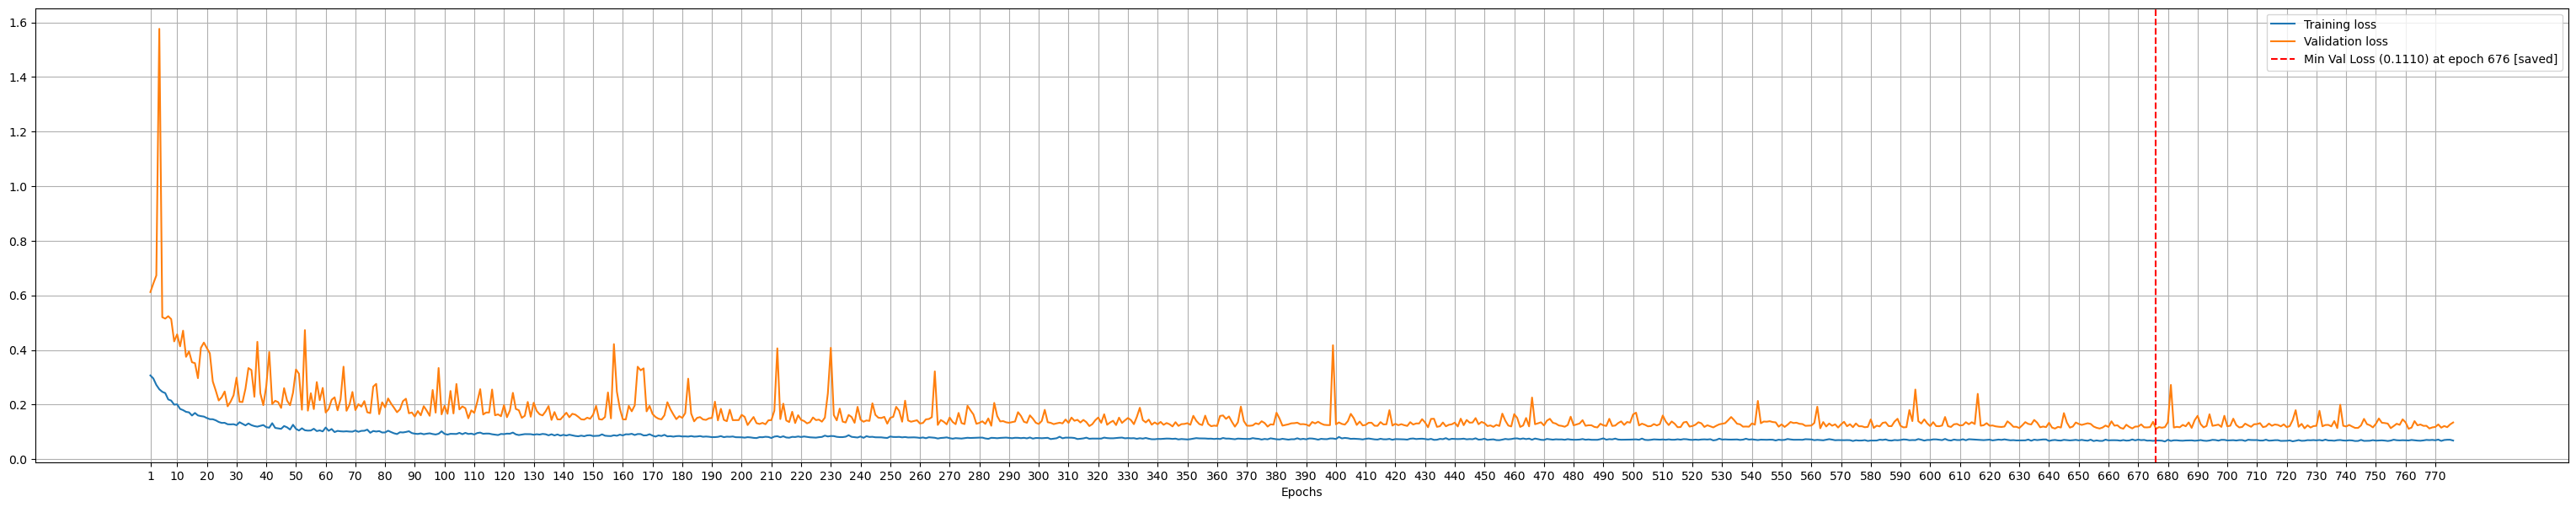

In [17]:
epochs_trained = len(history['train_loss'])
fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1, epochs_trained+1), history['train_loss'], label='Training loss')
plt.plot(np.arange(1, epochs_trained+1), history['val_loss'], label='Validation loss')

min_val_loss = min(history['val_loss'])
min_val_loss_epoch = history['val_loss'].index(min_val_loss) +1
plt.axvline(x=min_val_loss_epoch, color='red', linestyle='--', label=f'Min Val Loss ({min_val_loss:.4f}) at epoch {min_val_loss_epoch} [saved]')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)
#fig.autofmt_xdate()

plt.xlabel("Epochs")
plt.grid(True)
plt.legend()
plt.show()

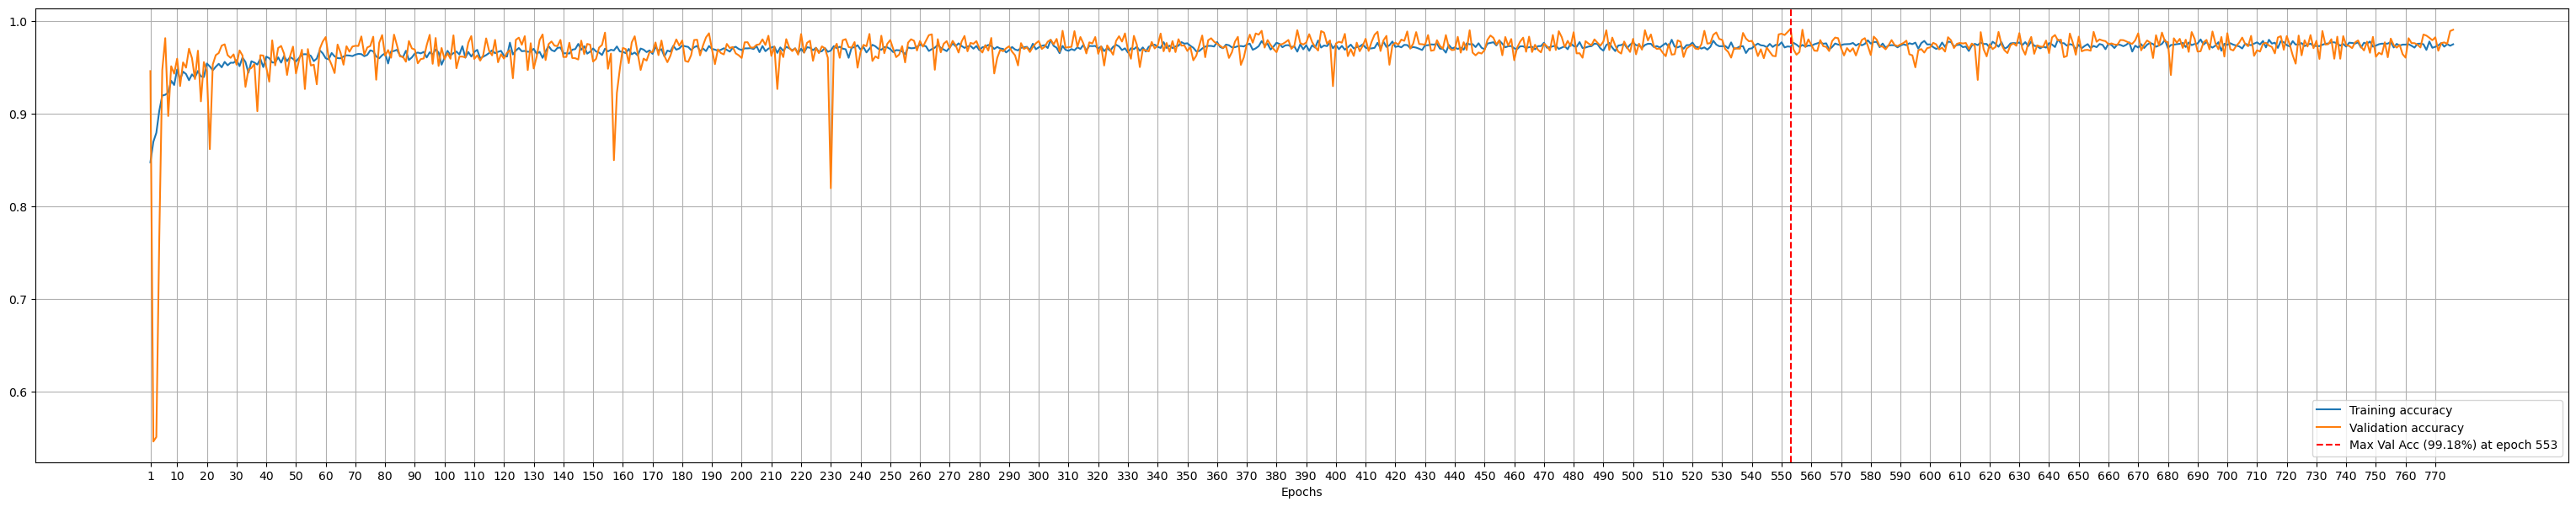

In [18]:
# from tensor to numpy
train_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['train_accuracy']]
val_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['val_accuracy']]
#print(train_accuracy_cpu)

fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1,epochs_trained+1), train_accuracy_cpu, label='Training accuracy')
plt.plot(np.arange(1,epochs_trained+1), val_accuracy_cpu, label='Validation accuracy')

max_val_acc = max(history['val_accuracy'])
max_val_acc_epoch = history['val_accuracy'].index(max_val_acc) +1
plt.axvline(x=max_val_acc_epoch, color='red', linestyle='--', label=f'Max Val Acc ({max_val_acc:.2f}%) at epoch {max_val_acc_epoch}')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)

#fig.autofmt_xdate()
plt.xlabel("Epochs")
plt.grid()
plt.legend()
plt.show()

**TEST**

In [19]:
# create model and load saved state 
# #model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)
# load_model_path = './trained_models/20250126_214831_UNet_0.06924
# model.load_state_dict(torch.load(load_model_path))
model.to(device)
model.eval()     # !!! set the dropout and batch normalization layers to evaluation mode

UNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128, e

In [20]:
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # evaluation at native resolution
    # v2.RandomRotation(degrees=(-180, 180)),
    # v2.RandomHorizontalFlip(),
    # v2.RandomVerticalFlip(),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    # v2.GaussianNoise(),
    # v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 1)),
    #transforms.ToTensor(),    # already tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

# load test images
test_img_dir = './data/CHASE/test/images'
test_gt_dir = './data/CHASE/test/2nd_manual'

test_dataset = Dataset(test_img_dir, test_gt_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [21]:
#check test image
for img, gt, img_name in test_loader:
    print(f"Shape of image: {img.shape}")
    print(f"Shape of GT: {gt.shape}")
    print(f"Name of image: {img_name[0]}") 
    break  # just one

Shape of image: torch.Size([1, 3, 512, 512])
Shape of GT: torch.Size([1, 1, 512, 512])
Name of image: 01_test.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


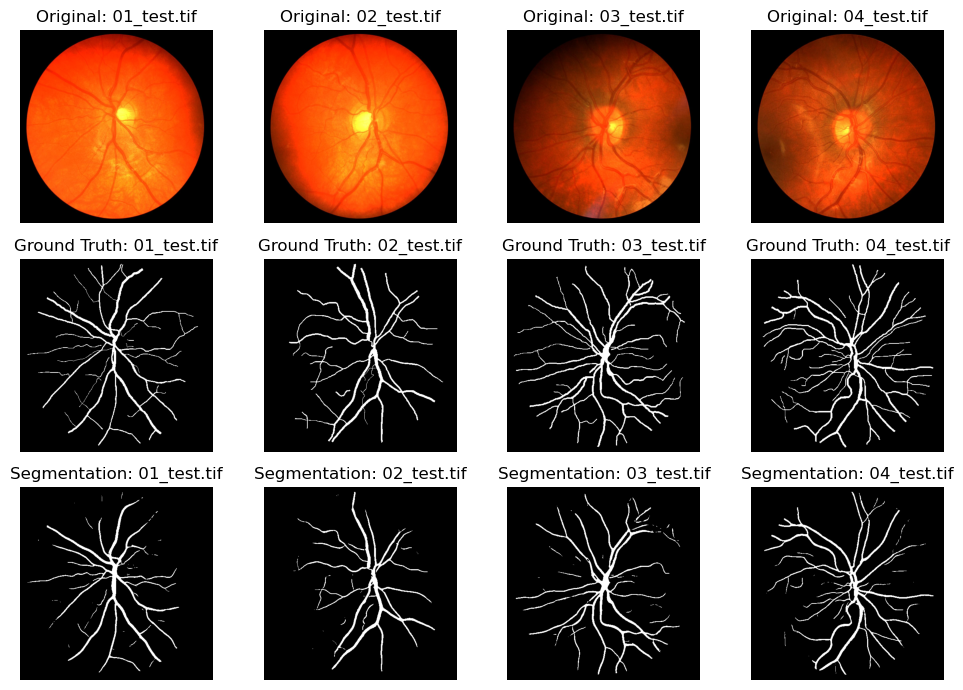

In [22]:
model.eval()   # done before, but just in case...

num_images = 4  # number of images to show
fig, axes = plt.subplots(3, num_images, figsize=(10, 7))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to cuda
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # convert to 0 or 1

        # convert output to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()

        # original test images
        axes[0, i].imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))  # from tensor to image
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original: {image_name[0]}")
        
        # test images ground truth segmentations
        axes[1, i].imshow(gt_img, cmap='gray')  # grayscale
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Ground Truth: {image_name[0]}")

        # test images predicted segmentations
        axes[2, i].imshow(output_img, cmap='gray')  # grayscale
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Segmentation: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

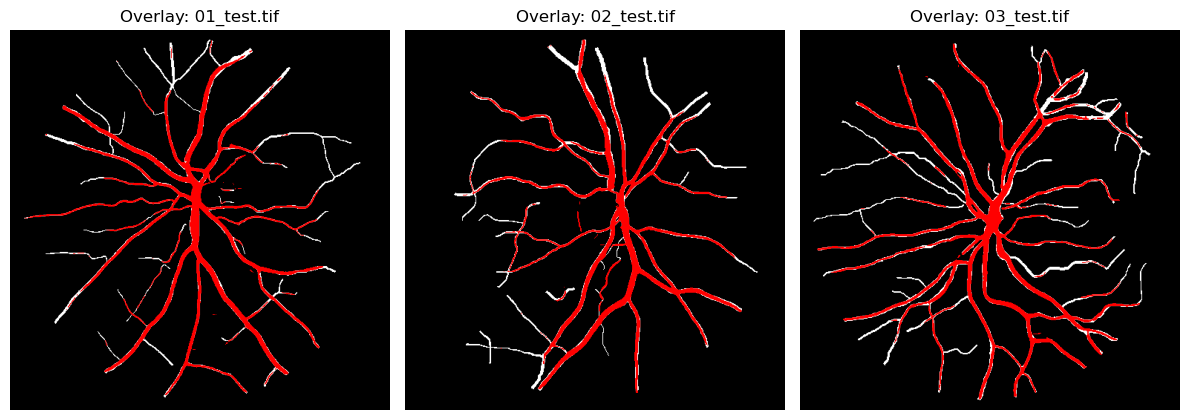

In [23]:
model.eval()   # done before, but just in case...

num_images = 3   # number of images to show
fig, axes = plt.subplots(1, num_images, figsize=(12, 8))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to CUDA
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # binarize prediction

        # convert prediction to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()  # gt as image

        # Mostrar ground truth como fondo en escala de grises
        axes[i].imshow(gt_img, cmap='gray')  # Fondo: ground truth
        
        # Crear imagen RGBA para superponer
        overlay = np.zeros((*output_img.shape, 4))  # Crear un mapa RGBA
        overlay[..., 0] = 1  # Canal rojo
        overlay[..., 3] = output_img  # Canal alfa (0 para transparente, 1 para opaco)
        
        axes[i].imshow(overlay)  # Superposición en RGBA
        
        axes[i].axis('off')
        axes[i].set_title(f"Overlay: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

**ROC, AUC, Test Accuracy, Dice score, MCC, ccDice**


Dice score: 0.7682

MCC: 0.7581

ccDice score: 0.1086

Test Accuracy: 0.9711

F1 Score: 0.7690




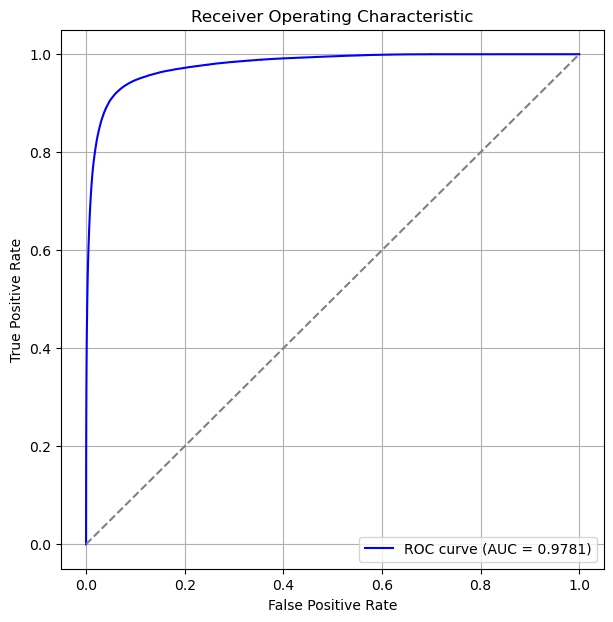

In [24]:
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from utils.dice_score import dice_score                     # custom function to calculate dice score
from utils.matthews_corr_coef import matthews_corr_coef     # custom function to calculate MCC
from utils.ccDice_score import ccDice                       # modified ccDice score (only binary labels)
from skimage.measure import label                           # necessary for ccDice

calculate_ccdice = True    # yes or no. Forced to use CPU: it takes long to compute (5 minutes just 8 images)

all_labels = []       # to store ground truth values for each pixel of each image
all_preds = []        # to store predicted values for each pixel of each image

dice_score_batches = []       # to store Dice score of each batch
mcc_batches = []              # to store MCC of each batch
if calculate_ccdice==True:
    ccdice_score_batches = []     # to store ccDice score of each batch

with torch.no_grad():  # no gradients needed
    for inputs, ground_truth, _ in test_loader:        # for each batch in test loader
        inputs = inputs.to(device)
        ground_truth = ground_truth.to(device)

        outputs = model(inputs)     # predict

        all_labels.append(ground_truth.cpu().numpy())       # real labels for each pixel (0 or 1) 
        all_preds.append(outputs.cpu().numpy())             # probabilities to belong to class 1, given by model
        
        dice = dice_score(outputs, ground_truth, threshold=0.5)
        dice_score_batches.append(dice.item())
        
        mcc = matthews_corr_coef(outputs, ground_truth, threshold=0.5)
        mcc_batches.append(mcc)

        if calculate_ccdice==True:
            y_pred_label, cc_pred = label(((outputs > 0.5).float()).cpu().numpy().squeeze(0), return_num=True)
            y_true_label, cc_true = label(ground_truth.cpu().numpy().squeeze(0), return_num=True)
            ccdice = ccDice(y_pred_label, cc_pred, y_true_label, cc_true, alpha=0.1)    # alpha is level of exigency to join 2 cc (low is permissive, 1.0 is max exigency)
            ccdice_score_batches.append(ccdice)

# compute mean dice score and print
mean_dice_score = torch.tensor(dice_score_batches).mean()
print(f"\nDice score: {mean_dice_score:.4f}")

# compute mean MCC and print
mean_mcc = torch.tensor(mcc_batches).mean()
print(f"\nMCC: {mean_mcc:.4f}")

# compute mean ccDice score and print
if calculate_ccdice==True:
    mean_ccdice_score = torch.tensor(ccdice_score_batches).mean()
    print(f"\nccDice score: {mean_ccdice_score:.4f}")

# list to numpy array
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# compute mean test accuracy and print
accuracy_sklearn = accuracy_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nTest Accuracy: {accuracy_sklearn:.4f}")

# compute mean F1 score accuracy and print
f1_sklearn = f1_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nF1 Score: {f1_sklearn:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(list(map(bool,all_labels.flatten())), all_preds.flatten())     # force labels to binary list (if not, error when transform.resize)

# AUC
roc_auc = auc(fpr, tpr)

# plot ROC
print("\n")
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

trained_models\20250205_220904_UNet_0.11097

In [25]:
# just to visualize the model architecture

'''from torch.utils.tensorboard import SummaryWriter
import torchvision

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/UNet')

# get some random training images
dataiter = iter(train_loader)
images, labels, _ = next(dataiter)

print(images.shape)
images = images.to(device)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

#img_grid = img_grid.unsqueeze(0) 

# write to tensorboard
writer.add_image('train_img', img_grid)

writer.add_graph(model, images)
writer.close()

# write in terminal --->   tensorboard --logdir=runs/Unet'''

'from torch.utils.tensorboard import SummaryWriter\nimport torchvision\n\n# default `log_dir` is "runs" - we\'ll be more specific here\nwriter = SummaryWriter(\'runs/UNet\')\n\n# get some random training images\ndataiter = iter(train_loader)\nimages, labels, _ = next(dataiter)\n\nprint(images.shape)\nimages = images.to(device)\n\n# create grid of images\nimg_grid = torchvision.utils.make_grid(images)\n\n#img_grid = img_grid.unsqueeze(0) \n\n# write to tensorboard\nwriter.add_image(\'train_img\', img_grid)\n\nwriter.add_graph(model, images)\nwriter.close()\n\n# write in terminal --->   tensorboard --logdir=runs/Unet'